In [1]:
import dill
from main.manipulation import Manipulation
from main.data_processing import evaluate_profile, get_social_welfare_of_alternative
import pandas as pd
import numpy as np
from main.manipulation_utils import get_children_generation_options, check_transitivity, one_cost_children_generation, useful_change
from IPython.display import display
from copy import copy
from matplotlib import pyplot as plt
import seaborn as sns
import os

import seaborn as sns

In [10]:
def calculate_qualities_of_winners(input_data, df_result, k, method):
    """
    input_data: list of profiles
    df_result: processed dataframe with the results
    """
    num_alt = len(input_data[0][0])
    alph_order = {}
    for i in range(num_alt):
        alph_order[i] = i
        
    winners = df_result['result'].apply(lambda d: d[max(d.keys())][0] if d else None).values
    same_winner_times = 0
    qualities = []
    for i in range(len(winners)):
        if not pd.isnull(winners[i]):
            true_win = evaluate_profile(input_data[i], k, method, alph_order)[0]
            if true_win == winners[i]:
                same_winner_times+=1
            qualities.append(get_social_welfare_of_alternative(input_data[i], true_win) - get_social_welfare_of_alternative(input_data[i], winners[i]))
    return qualities, same_winner_times

def get_qualities_of_winners(completeness, d_type, num_vot, num_alt, method, k, qualities_of_winners, input_data, dft):
    if (completeness, d_type, num_vot, num_alt, method, k) not in qualities_of_winners.keys():
        qualities, same_winner_times =calculate_qualities_of_winners(input_data[(num_vot, num_alt, d_type)], dft, k, method)
        qualities_of_winners[(completeness, d_type, num_vot, num_alt, method, k)]=(qualities, same_winner_times)
        with open('data/results/qualities_of_winners.pkl', 'wb') as f:
            dill.dump(qualities_of_winners, f)
    else:
        qualities, same_winner_times=qualities_of_winners[(completeness, d_type, num_vot, num_alt, method, k)]
    return qualities, same_winner_times

# data load and set-up

In [3]:
with open('data/results/total_result.pkl', 'rb') as f:
    total_result = dill.load(f)

### calculate quality of winners

In [4]:
with open('data/our_data_complete.pkl', 'rb') as f:
    input_data_complete = dill.load(f)
with open('data/our_data_incomplete.pkl', 'rb') as f:
    input_data_incomplete = dill.load(f)

In [5]:
data_df = pd.DataFrame(total_result).T
data_df.columns = ['convergence', 'result']

In [6]:
data_df

convergence  \
3 10 ic   131 1 approval 0 True True True True         True   
          132 1 approval 0 True True True True         True   
          133 1 approval 0 True True True True         True   
          134 1 approval 0 True True True True         True   
          135 1 approval 0 True True True True         True   
...                                                     ...   
5 50 2urn 195 4 approval 0 True True True False        True   
          196 4 approval 0 True True True False        True   
          197 4 approval 0 True True True False        True   
          198 4 approval 0 True True True False        True   
          199 4 approval 0 True True True False        True   

                                                                                            result  
3 10 ic   131 1 approval 0 True True True True                                         {0: (1, 8)}  
          132 1 approval 0 True True True True                                                  {}  
          133 1 approval 0 True True True True                   {0: (0, 6), 1: (2, 4), 2: (0, 1)}  
          134 1 approval 0 True True True True                                                  {}  
          135 1 approval 0 True True True True                   {0: (0, 1), 1: (2, 7), 2: (0, 4)}  
...                                                                                            ...  
5 50 2urn 195 4 approval 0 True True True False  {0: (2, 37), 1: (4, 48), 2: (0, 9), 3: (2, 15)...  
          196 4 approval 0 True True True False  {0: (3, 13), 1: (4, 25), 2: (0, 24), 3: (2, 45...  
          197 4 approval 0 True True True False  {0: (1, 44), 1: (0, 36), 2: (1, 40), 3: (2, 33...  
          198 4 approval 0 True True True False  {0: (2, 7), 1: (3, 41), 2: (1, 7), 3: (3, 18),...  
          199 4 approval 0 True True True False  {0: (2, 49), 1: (3, 19), 2: (0, 24), 3: (1, 18...  

[30292 rows x 2 columns]

# Plots
to check:

1. number of rounds to convergence (putting an upper bound for cycles)

2. number of non-manipulable profiles

3. quality of winner in truthful vs. equilibrium profile. 
- Definition: input: one alternative `a` and one truthful profile. For every voter, look at her preference. The quality of the alternative a is #1s - #(-1s) in the row of `a`. Sum up the quality of a for all voters. This is the social welfare.

Calculate social welfare for truthful winner and convergence winner, and subtract latter from former.

4. number of times where the winner was the same as the truthful one
----------------------------------------------------


for plotting:

1. x: number of rounds ; y: percentage of profiles (in the 200) that have converged for this x
each plot includes: ic,2urn,complete,incomplete. Different plots for (n,m) 

2. x: indices (n, m, ic, 2urn, complete, incomplete) ; y: percentage of non-manipulable profiles

3. x: quality of winner; y: percentage of profiles (in the 200) that have that quality of winner
each plot includes: ic,2urn,complete,incomplete. Different plots for (n,m) 

4. x: indices (n, m, ic, 2urn, complete, incomplete) ; y: percentage of profiles with true winner

In [11]:
if os.path.isfile('data/results/qualities_of_winners.pkl'):
    with open('data/results/qualities_of_winners.pkl', 'rb') as f:
        qualities_of_winners = dill.load(f)
else:
    qualities_of_winners = {}

In [12]:
inds = []
convergence_rounds_all = {}
qualities_all = {}
same_winner_times_all = {}

for completeness in [True, False]:
    for num_alt in [3, 4, 5]:
        for d_type in ["2urn", "ic"]:
            for num_vot in [10, 20, 50]:
                for method in ['approval', 'veto']:
                    for k in [1, num_alt-1]: # [1, num_alt-1]
                        try:
                            dft = data_df.loc[(num_alt, num_vot, d_type, slice(None), k, method, 0, True, True, True, completeness)]
                            convergence_rounds = dft['result'].apply(lambda d: max(d.keys())+1 if d else 0)
                            input_data = {True: input_data_complete, False: input_data_incomplete}[completeness]
                            
                            qualities, same_winner_times= get_qualities_of_winners(completeness, d_type, num_vot, num_alt, method, k, qualities_of_winners, input_data, dft)
                            
#                             if (completeness, d_type, num_vot, num_alt, method, k) not in qualities_of_winners.keys():
#                                 qualities, same_winner_times =calculate_qualities_of_winners(input_data[(num_vot, num_alt, d_type)], dft, k, method)
#                                 qualities_of_winners[(completeness, d_type, num_vot, num_alt, method, k)]=(qualities, same_winner_times)
#                                 with open('data/results/qualities_of_winners.pkl', 'wb') as f:
#                                     dill.dump(qualities_of_winners, f)
#                             else:
#                                 qualities, same_winner_times=qualities_of_winners[(completeness, d_type, num_vot, num_alt, method, k)]

                            inds.append((num_alt, num_vot, d_type, completeness, method, k))
                            idx = inds[-1]
                            convergence_rounds_all[idx]=convergence_rounds
                            qualities_all[idx]=pd.Series(qualities)
                            same_winner_times_all[idx]=same_winner_times

                            print(f'k: {k}, {method}, num_alt: {num_alt}, num_vot: {num_vot}, d_type: {d_type}: percent of converged {dft["convergence"].max()*100}%, convergence rounds: mean={convergence_rounds.mean()}, max={convergence_rounds.max()}, std={convergence_rounds.std():.2f}, mean_quality: {np.mean(qualities):.2f}, times with no winner change: {same_winner_times}')
                        except KeyError:
                            pass

k: 1, approval, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.325, max=10, std=1.04, mean_quality: -0.26, times with no winner change: 8
k: 2, approval, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.615, max=7, std=1.24, mean_quality: -0.94, times with no winner change: 20
k: 1, veto, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=1.59, max=29, std=3.38, mean_quality: -2.07, times with no winner change: 31
k: 2, veto, num_alt: 3, num_vot: 10, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.255, max=3, std=0.67, mean_quality: -0.39, times with no winner change: 8
k: 1, approval, num_alt: 3, num_vot: 20, d_type: 2urn: percent of converged 100%, convergence rounds: mean=0.27, max=5, std=0.85, mean_quality: -1.91, times with no winner change: 11
k: 2, approval, num_alt: 3, num_vot: 20, d_type: 2urn: percent of converged 100%, converge

<ipython-input-12-e89ebe5ce230>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  qualities_all[idx]=pd.Series(qualities)
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/panos/anaconda3/envs/iterative_voting/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


k: 1, approval, num_alt: 3, num_vot: 10, d_type: ic: percent of converged 100%, convergence rounds: mean=0.155, max=4, std=0.49, mean_quality: -0.61, times with no winner change: 5
k: 2, approval, num_alt: 3, num_vot: 10, d_type: ic: percent of converged 100%, convergence rounds: mean=1.485, max=10, std=1.95, mean_quality: -0.73, times with no winner change: 41
k: 1, veto, num_alt: 3, num_vot: 10, d_type: ic: percent of converged 100%, convergence rounds: mean=0.505, max=5, std=1.00, mean_quality: -0.87, times with no winner change: 24
k: 2, veto, num_alt: 3, num_vot: 10, d_type: ic: percent of converged 100%, convergence rounds: mean=1.135, max=7, std=1.51, mean_quality: -1.19, times with no winner change: 51
k: 1, approval, num_alt: 3, num_vot: 20, d_type: ic: percent of converged 100%, convergence rounds: mean=0.365, max=6, std=0.89, mean_quality: -1.23, times with no winner change: 20
k: 2, approval, num_alt: 3, num_vot: 20, d_type: ic: percent of converged 100%, convergence rounds

# one

In [13]:
df=pd.DataFrame(pd.concat(convergence_rounds_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']

In [14]:
df=df[df['result']!=0]
df=df[df['result']<100]

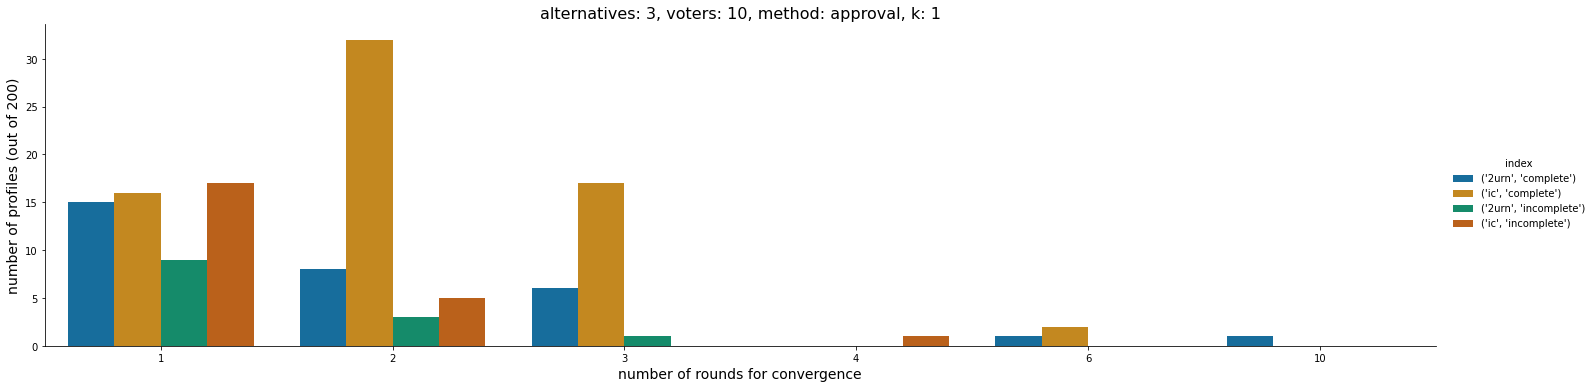

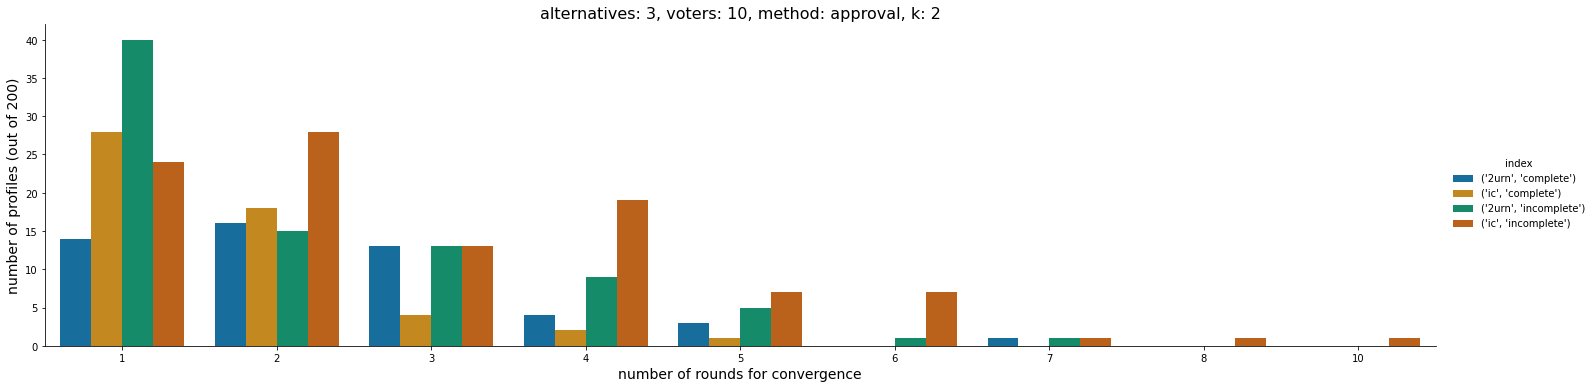

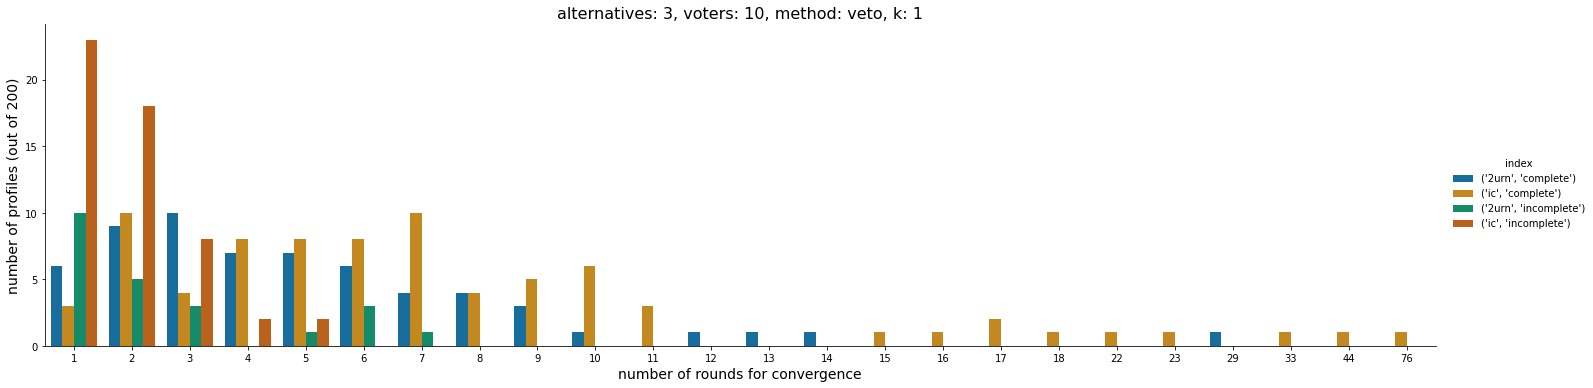

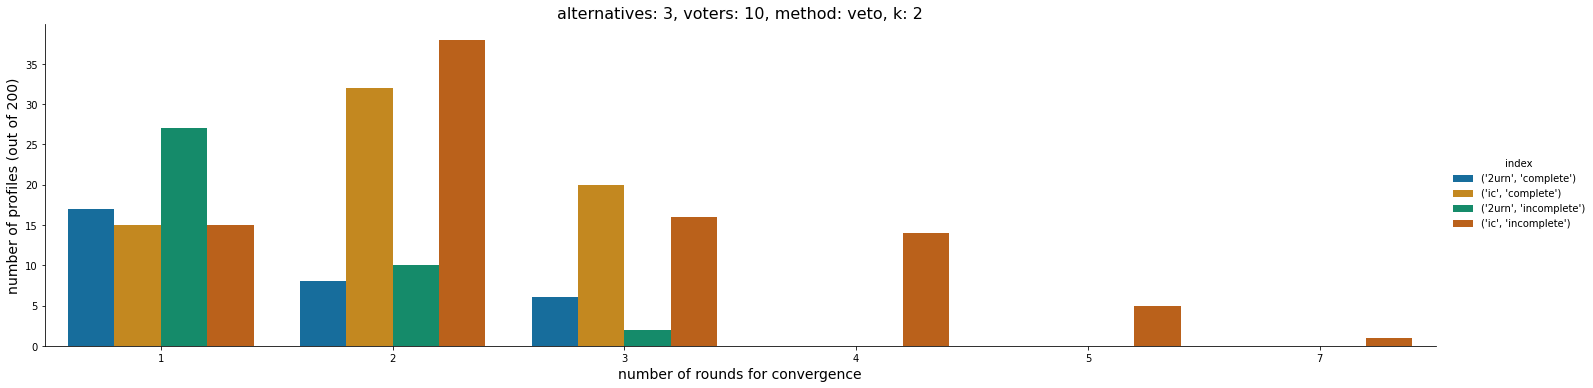

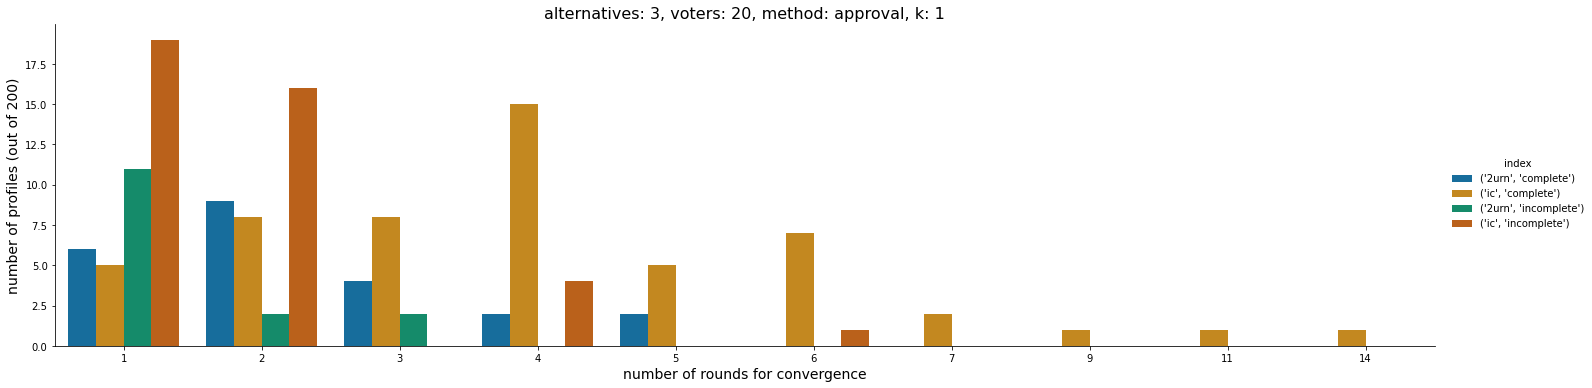

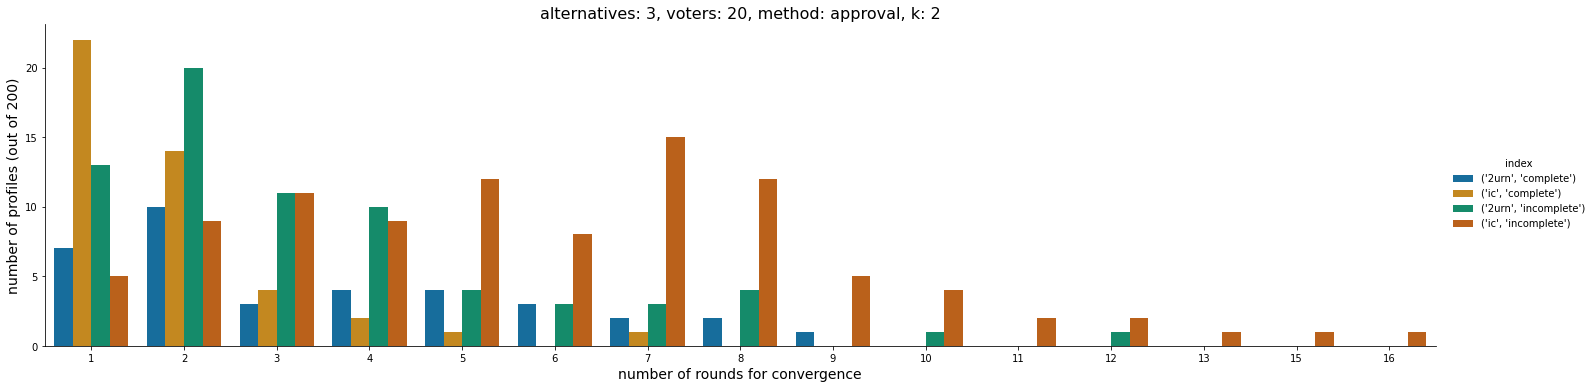

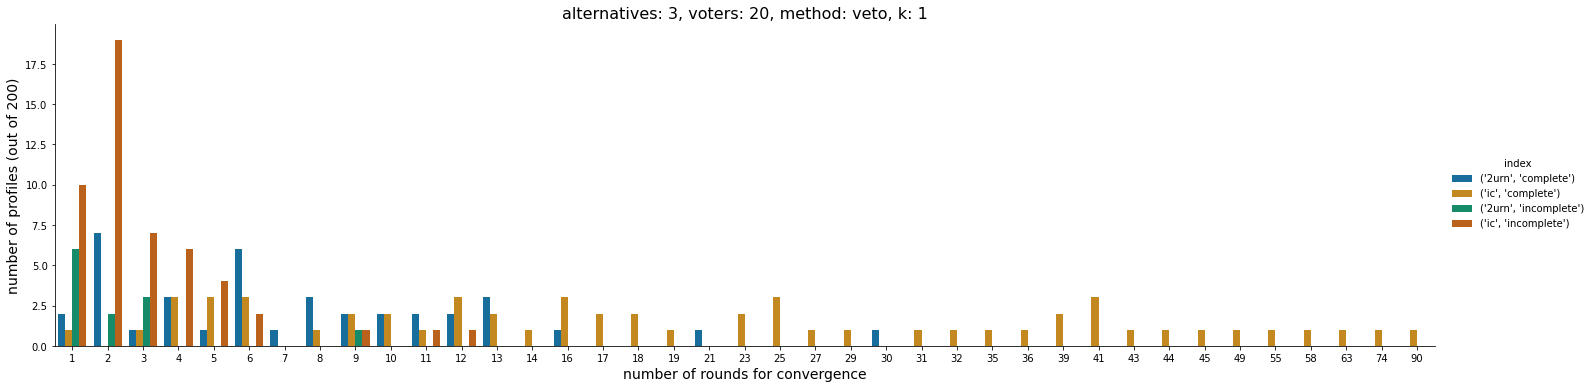

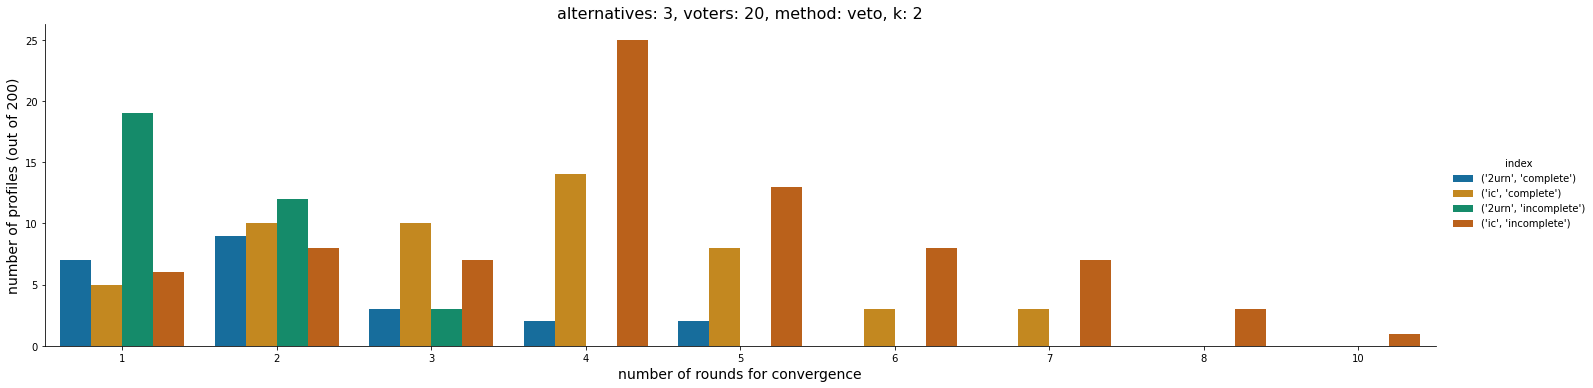

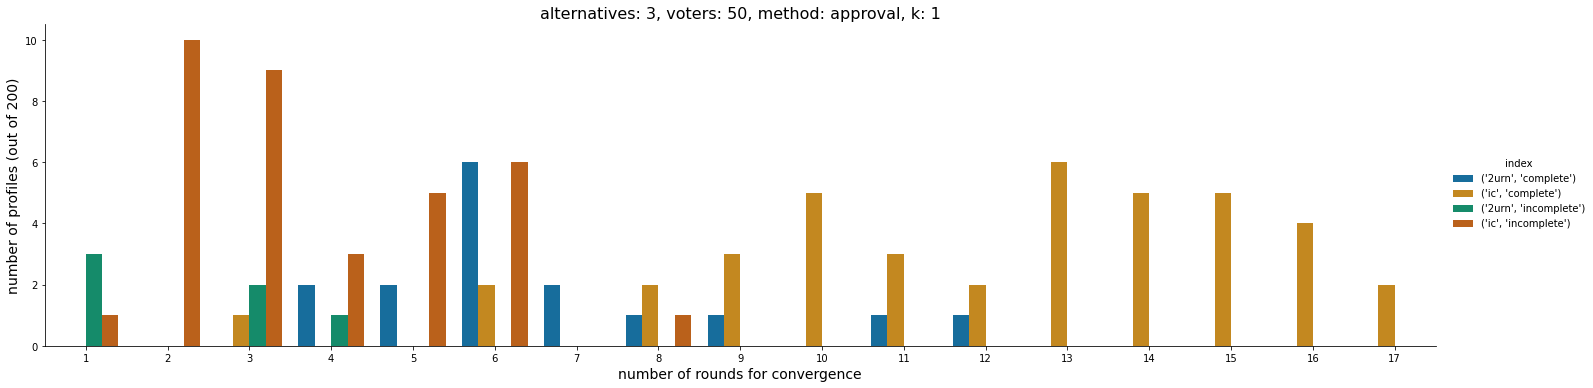

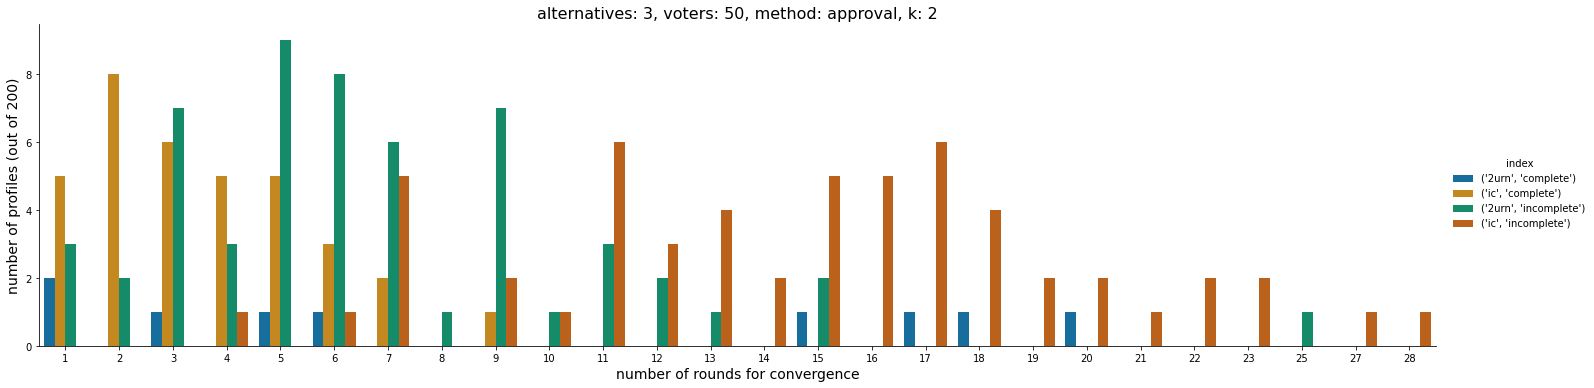

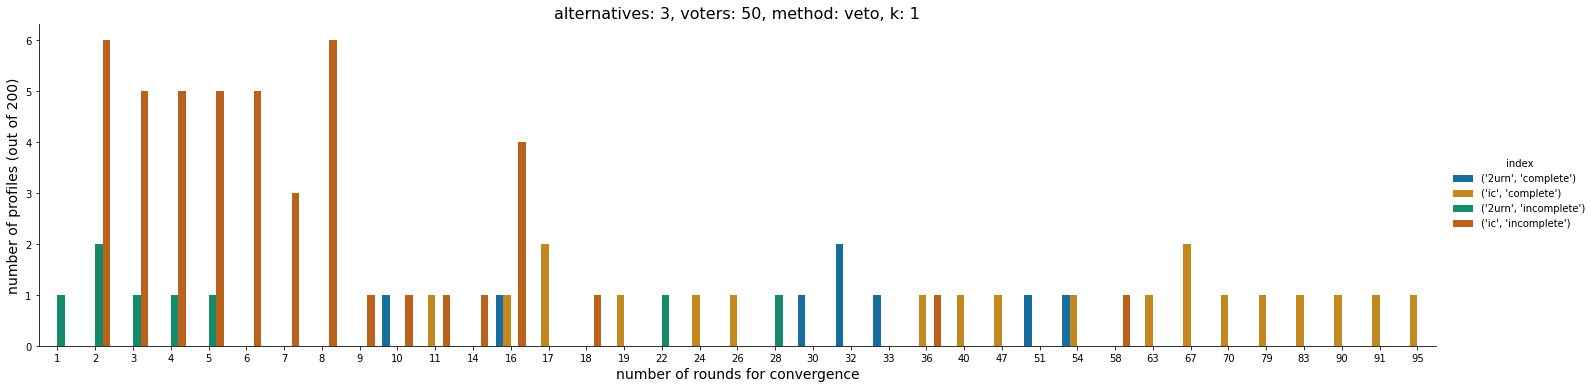

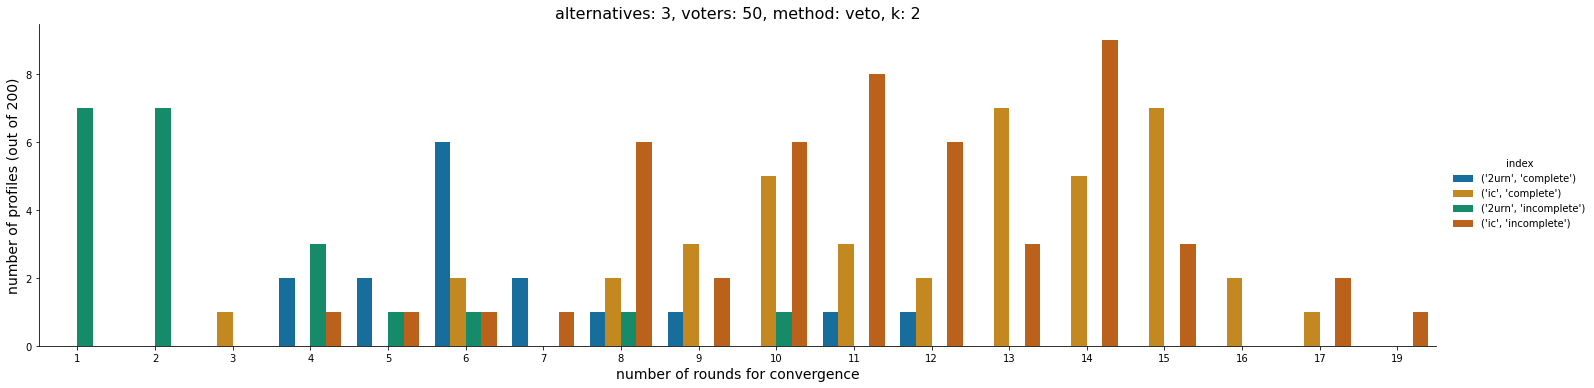

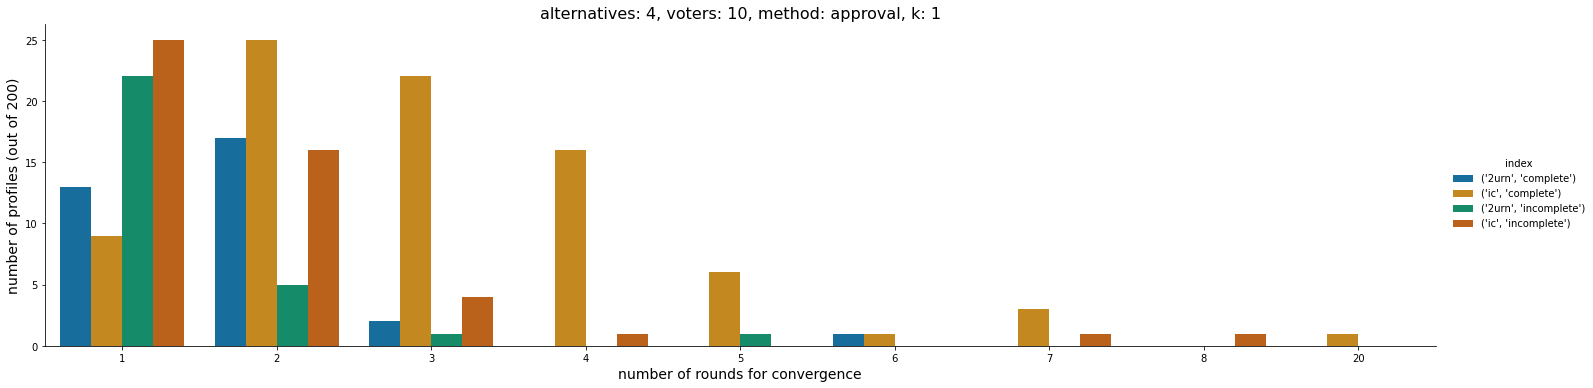

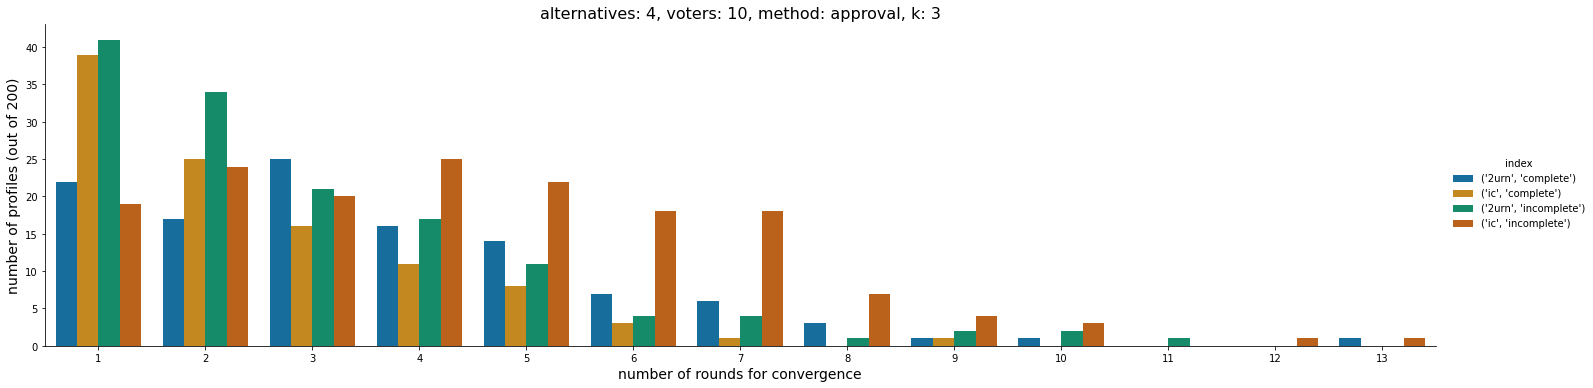

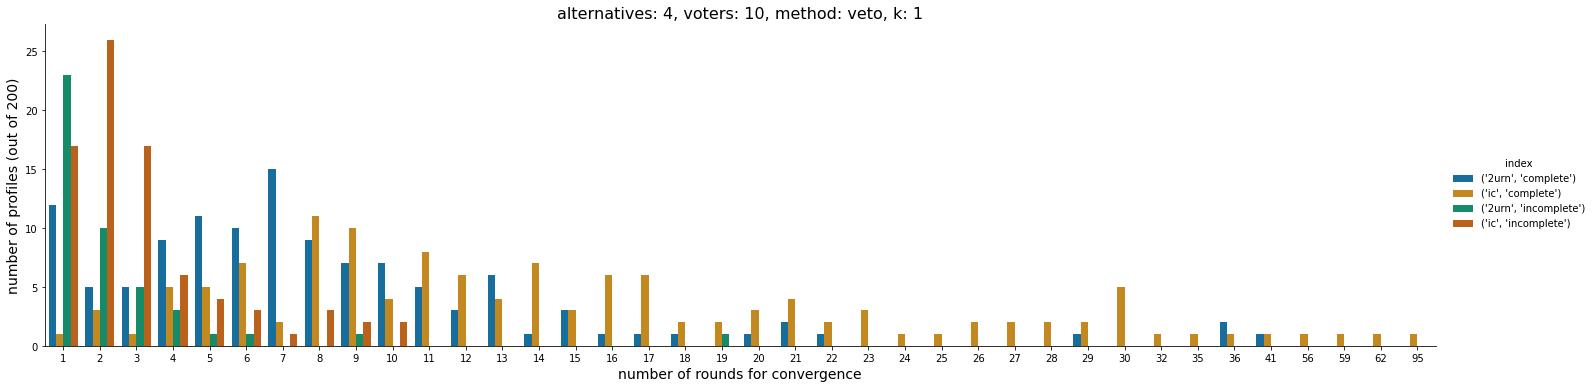

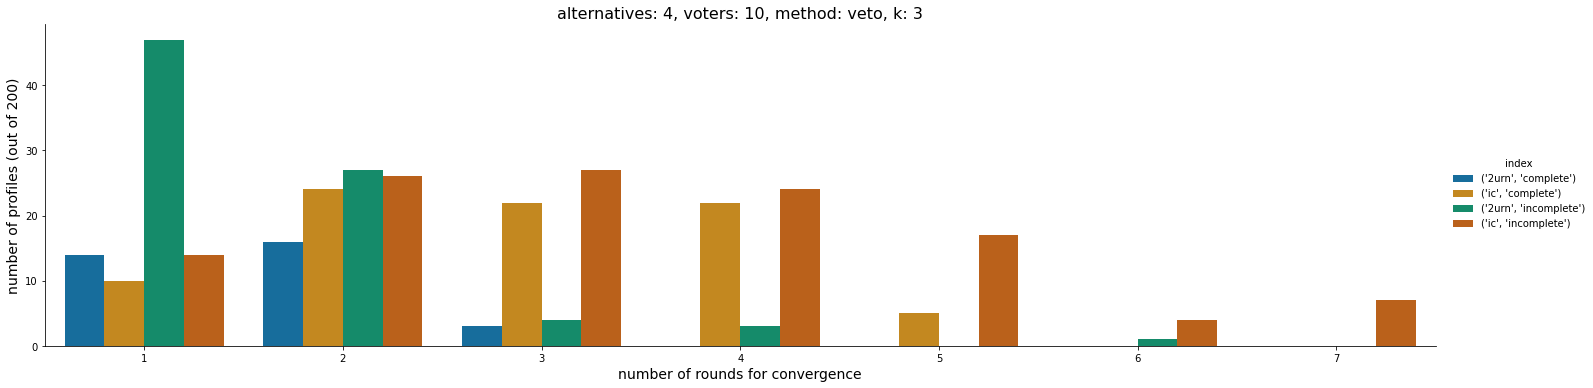

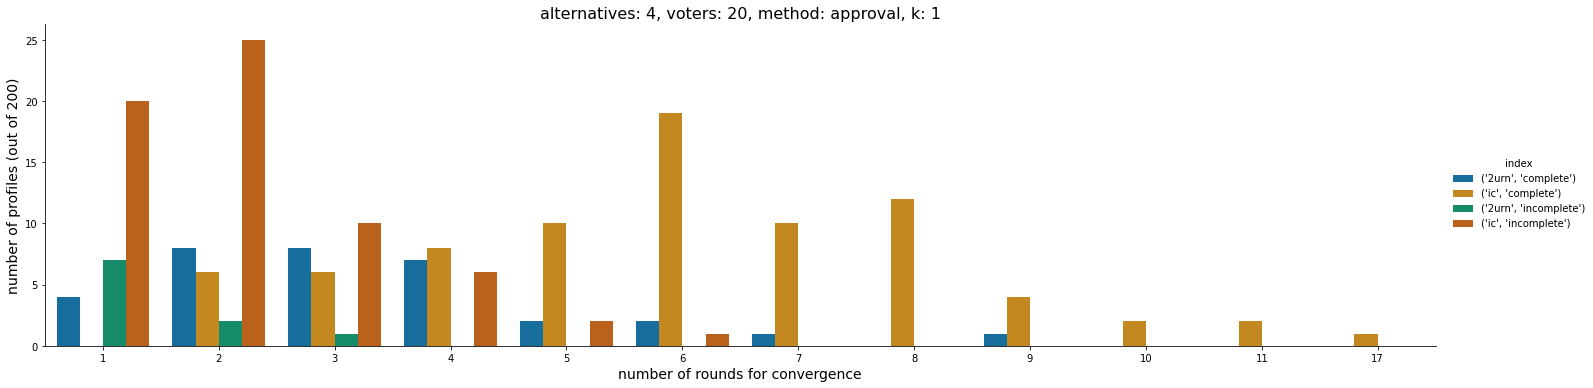

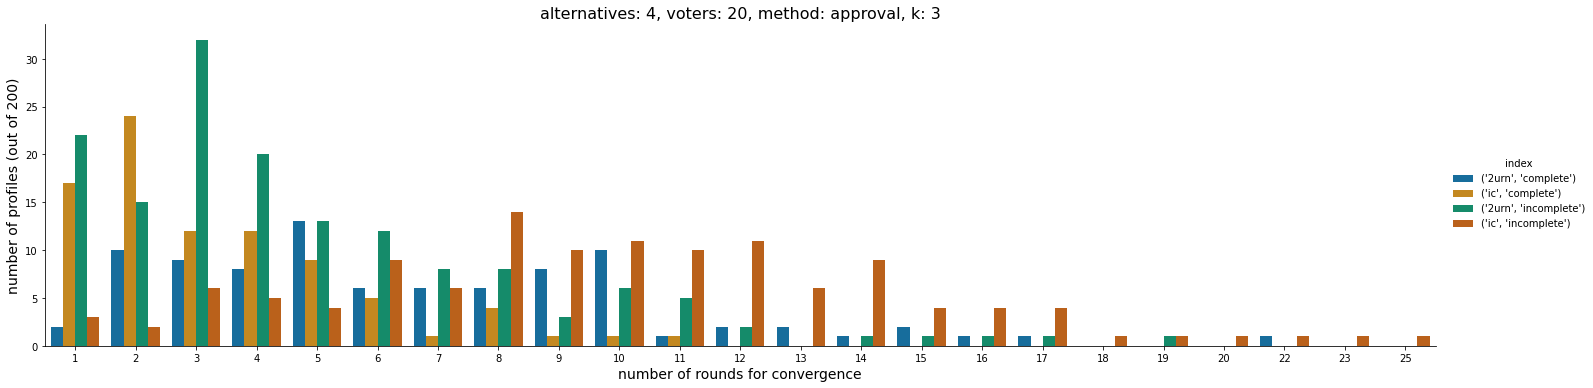

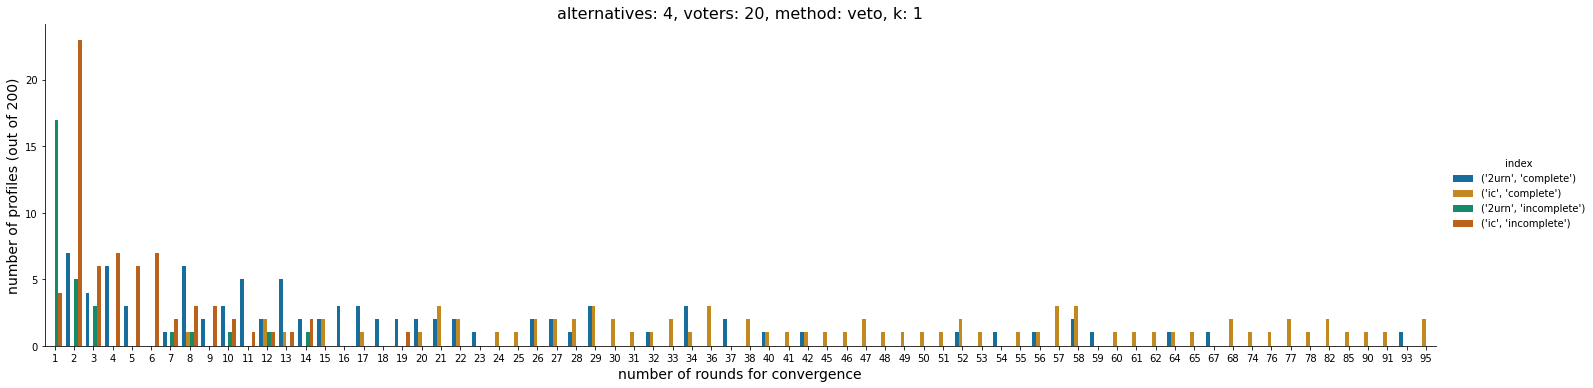

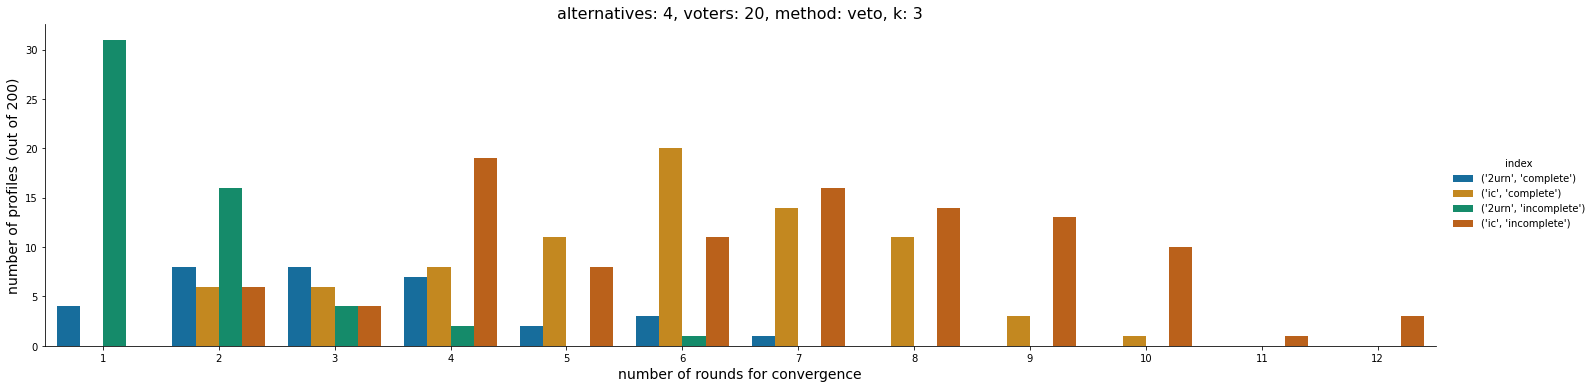

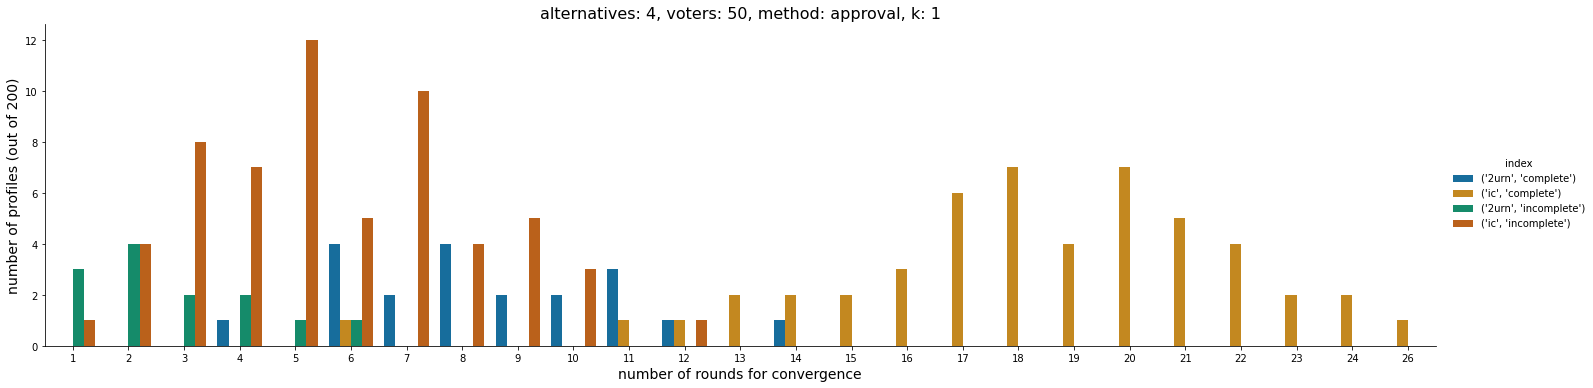

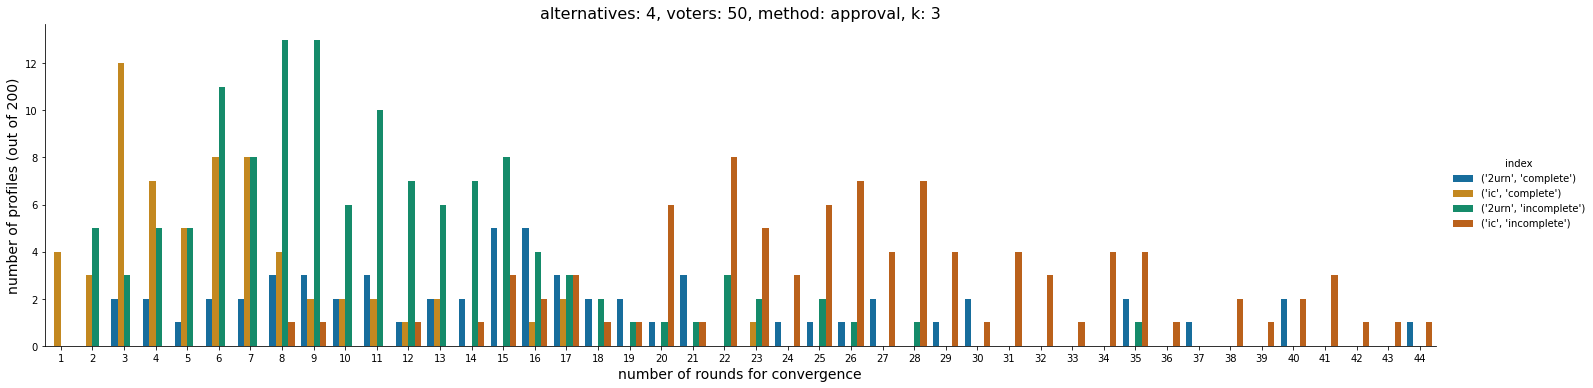

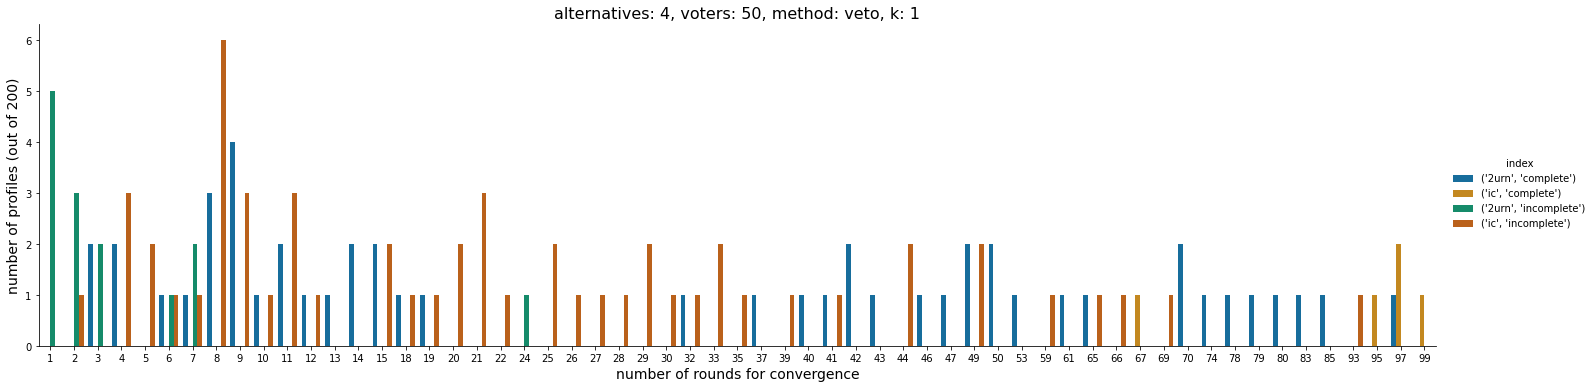

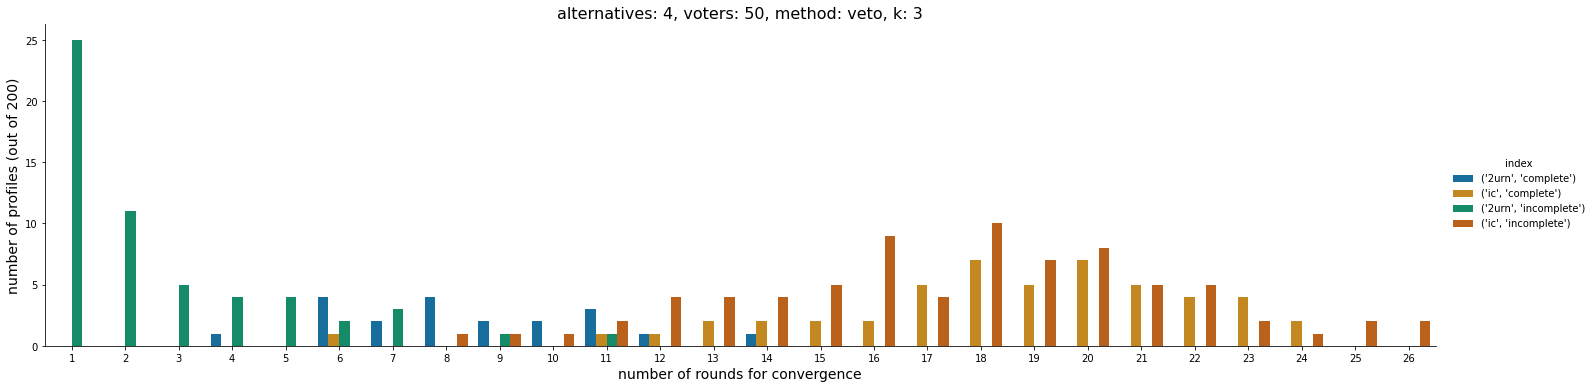

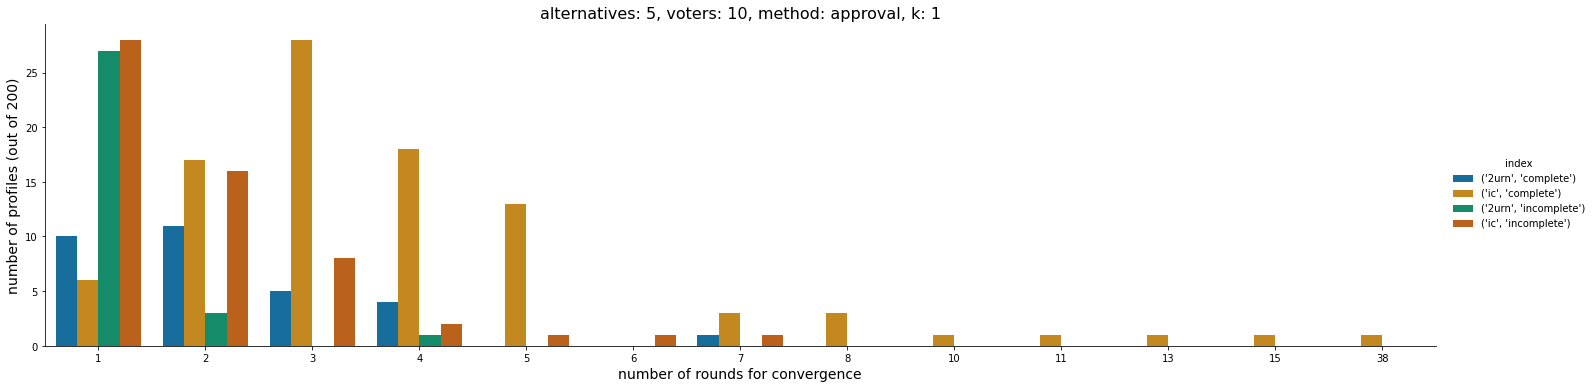

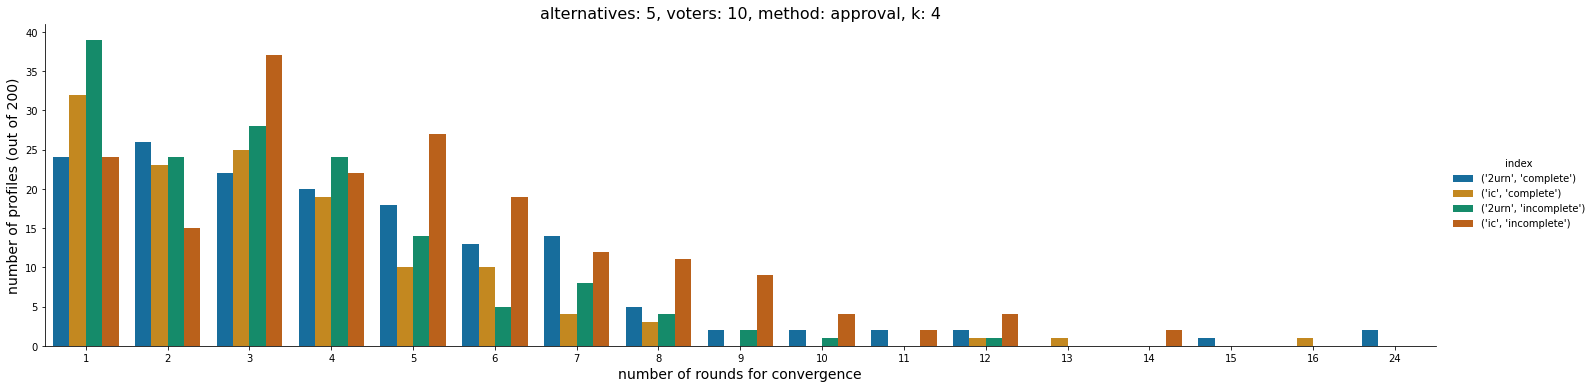

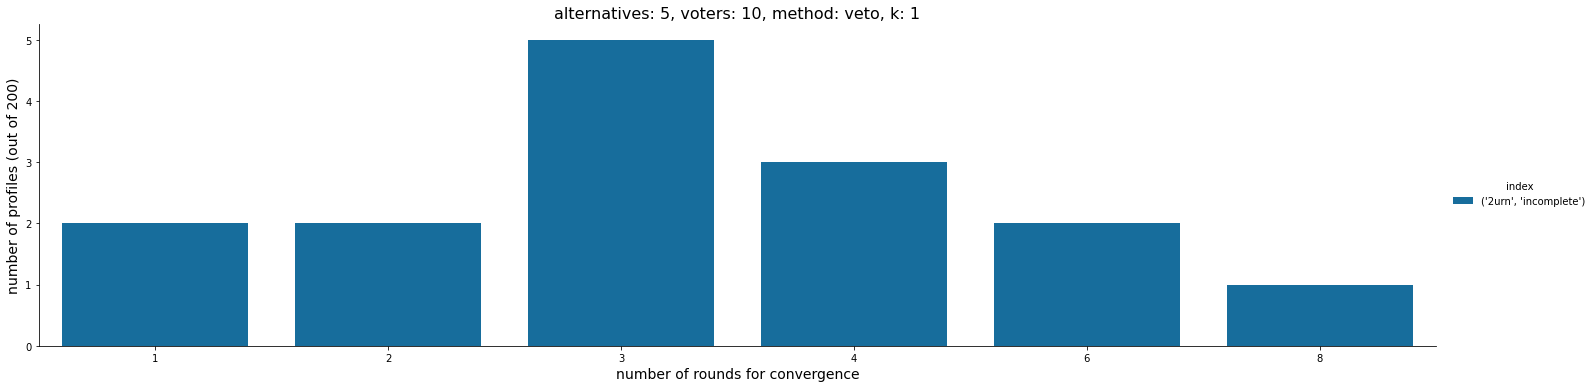

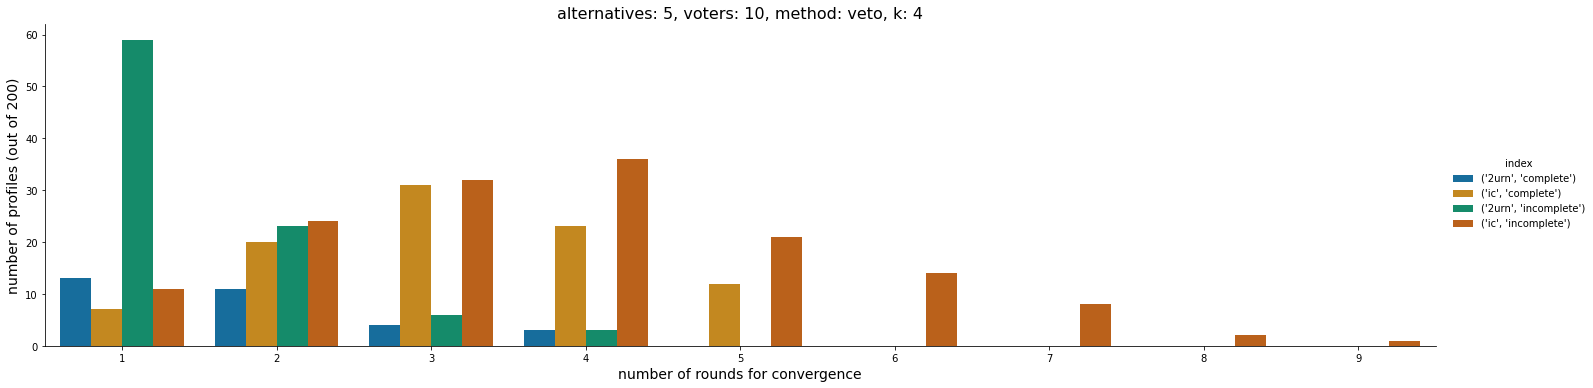

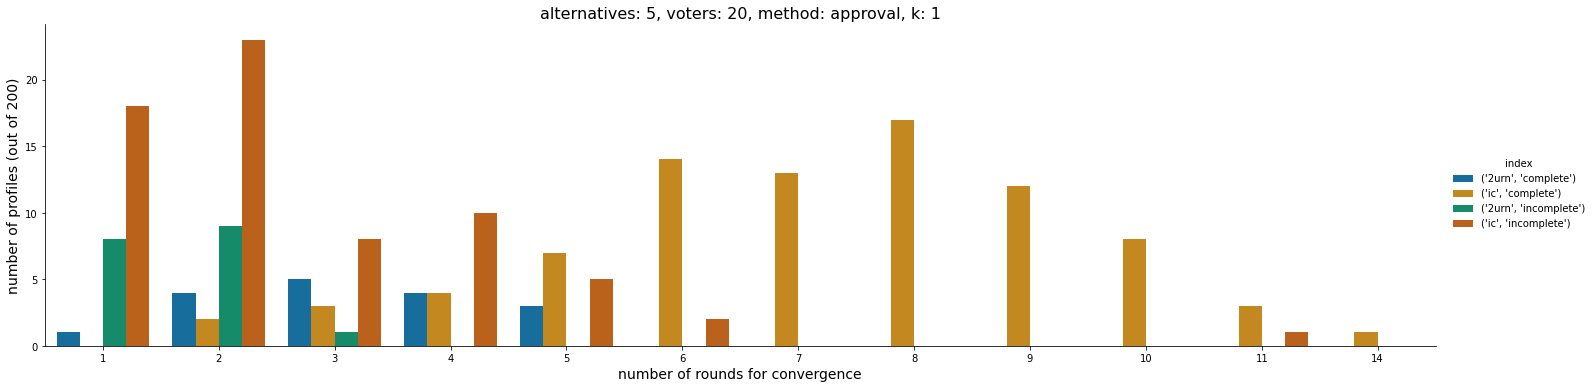

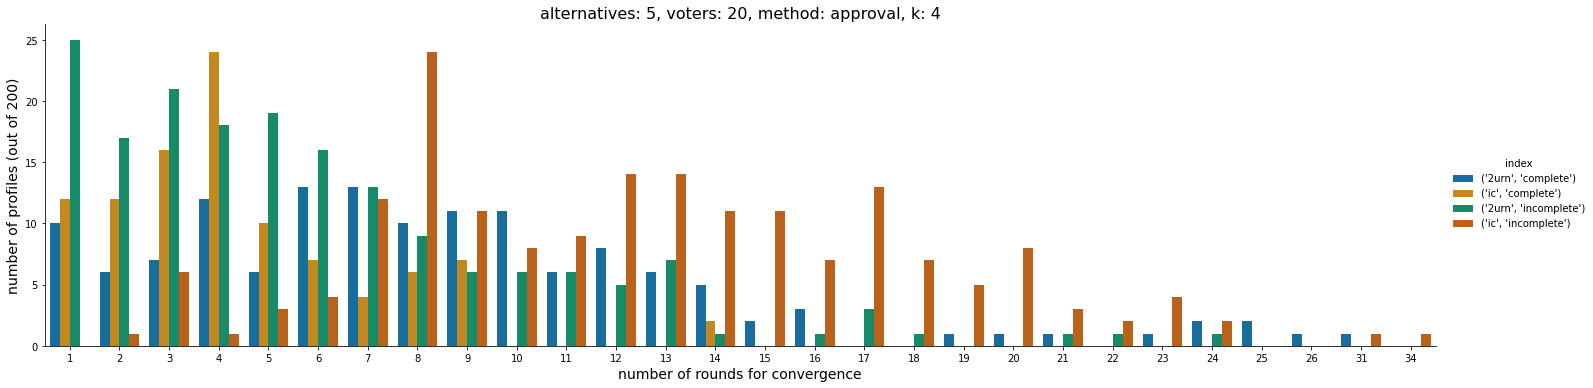

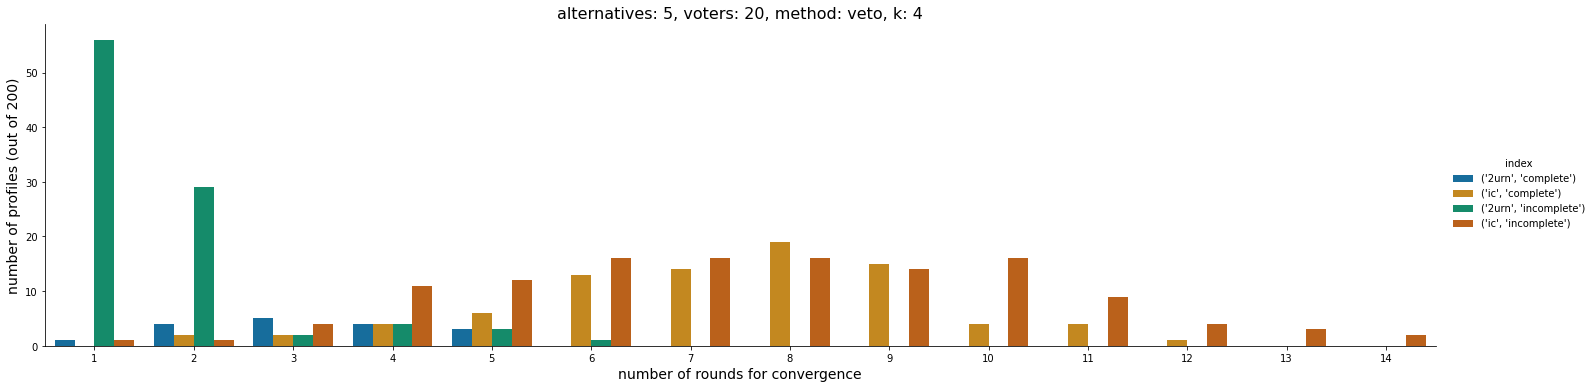

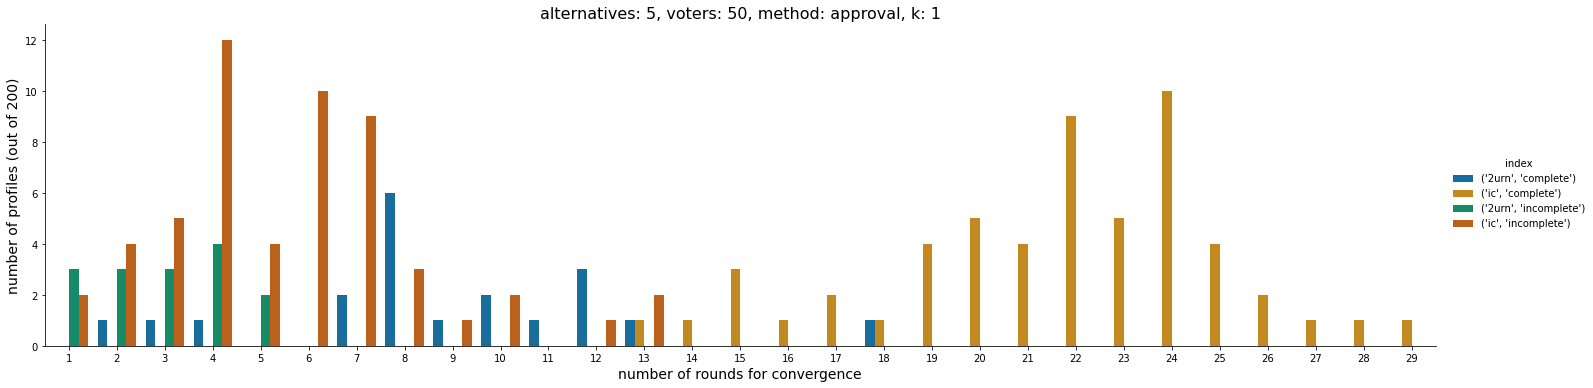

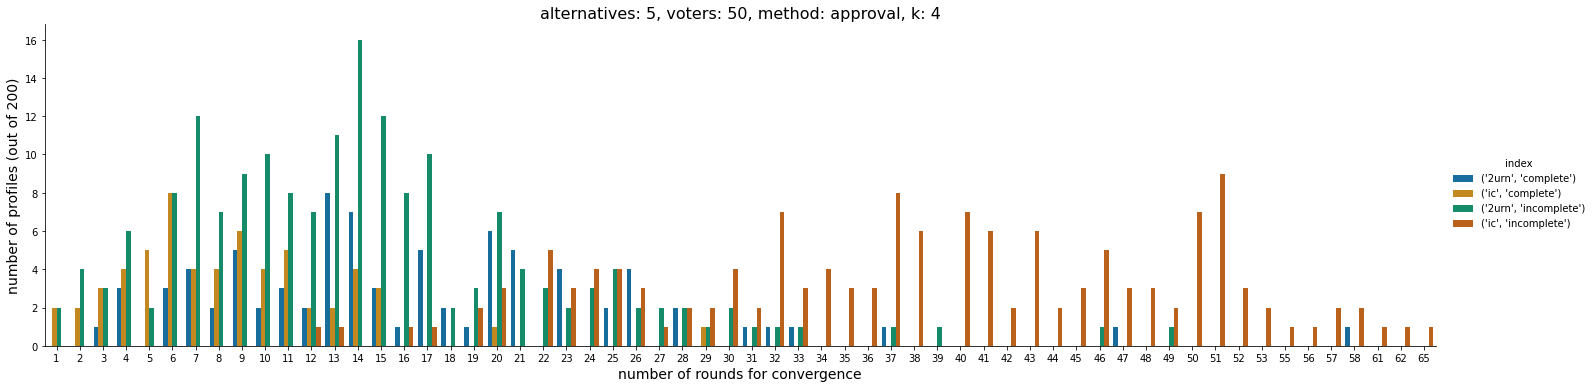

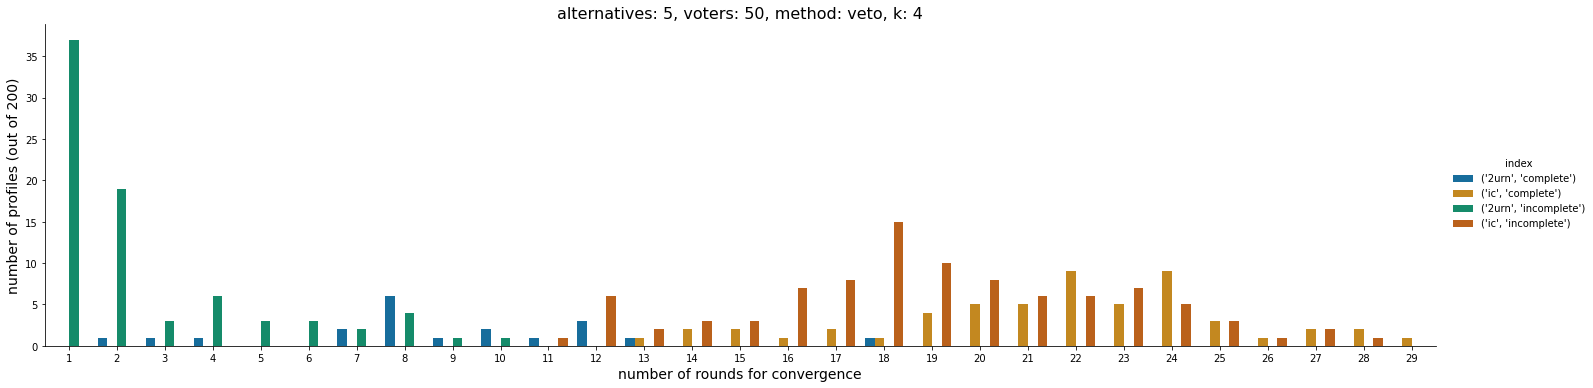

In [15]:
for num_alt in [3, 4, 5]:
    for num_vot in [10, 20, 50]:
        for method in ['approval', 'veto']:
            for k in [1, num_alt-1]:
                try:
                    dft = df.loc[(num_alt, num_vot, slice(None), slice(None), method, k)]
                    dft.reset_index(inplace=True)
                    dft['index'] = dft.apply(lambda row: (row['data_type'], {True: 'complete', False: 'incomplete'}[row['completeness']]), axis=1)
                    sns.catplot(data=dft, x ='result', kind='count', hue='index', height=5, aspect=4, palette="colorblind")
                    plt.title(f'alternatives: {num_alt}, voters: {num_vot}, method: {method}, k: {k}', fontsize=16)
                    plt.ylabel('number of profiles (out of 200)', fontsize=14)
                    plt.xlabel('number of rounds for convergence', fontsize=14)
                    plt.show()
                except (KeyError, ValueError):
                    pass

# three

In [16]:
df=pd.DataFrame(pd.concat(qualities_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']

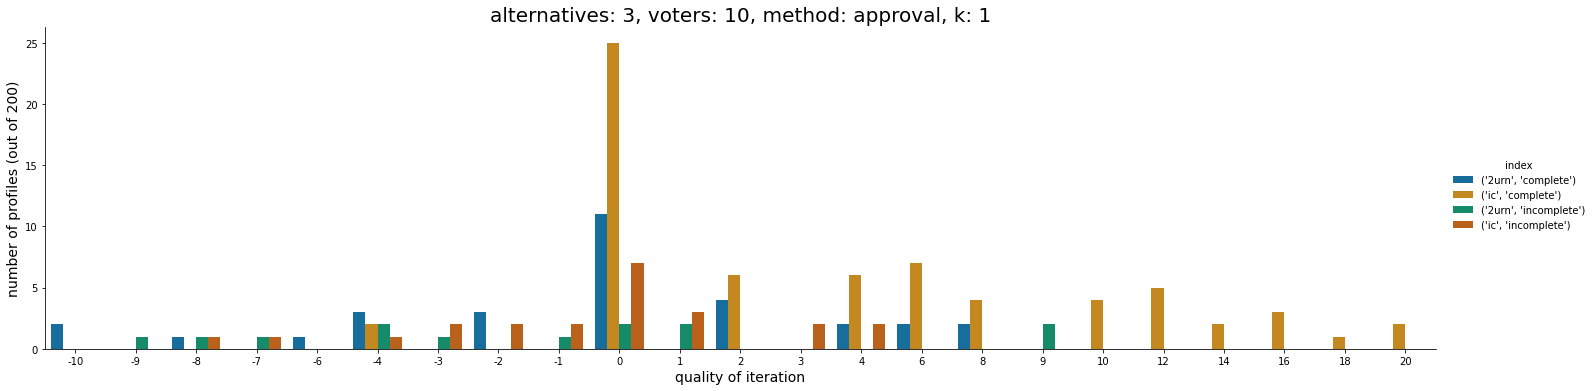

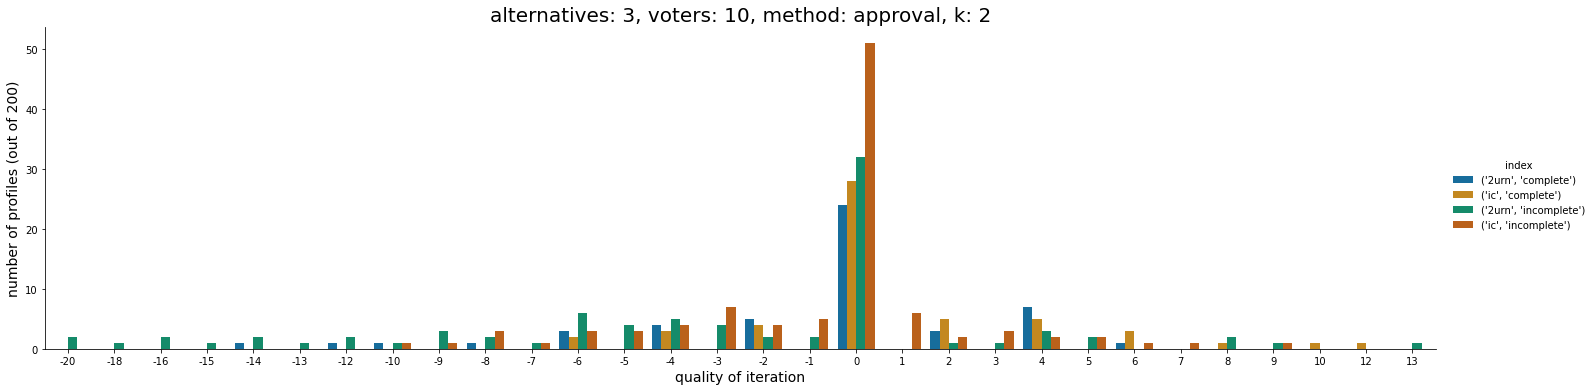

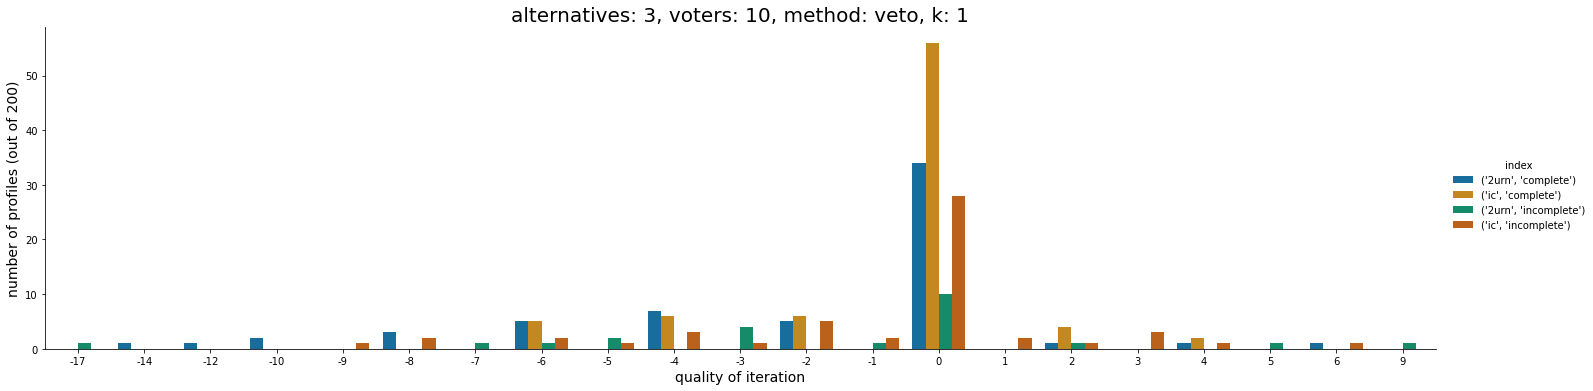

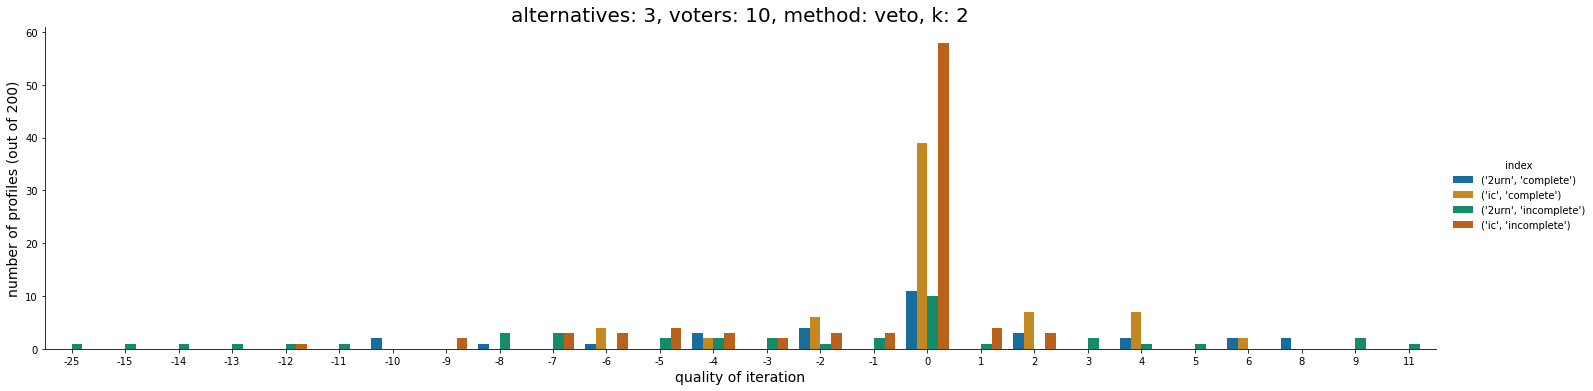

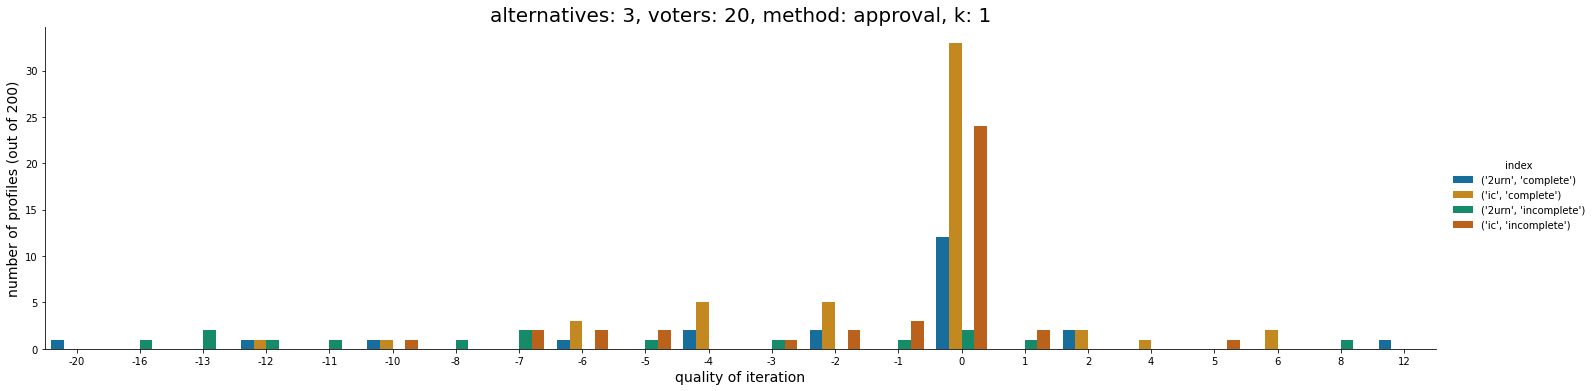

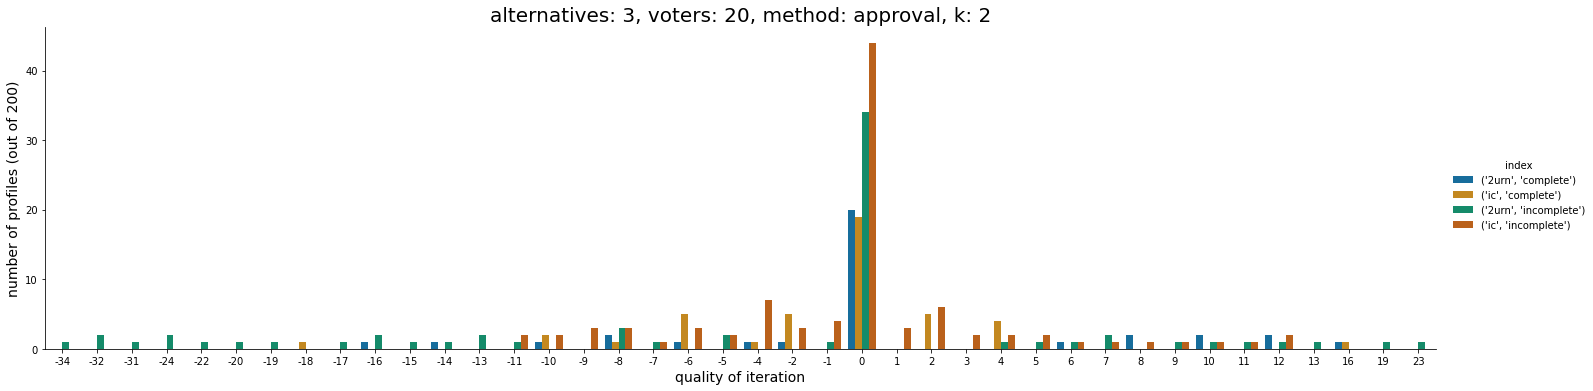

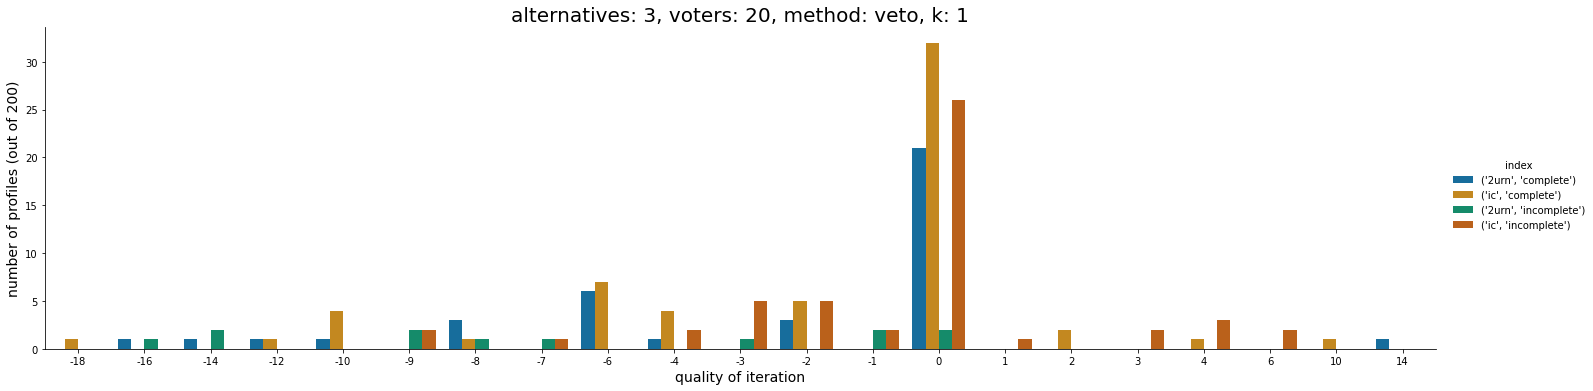

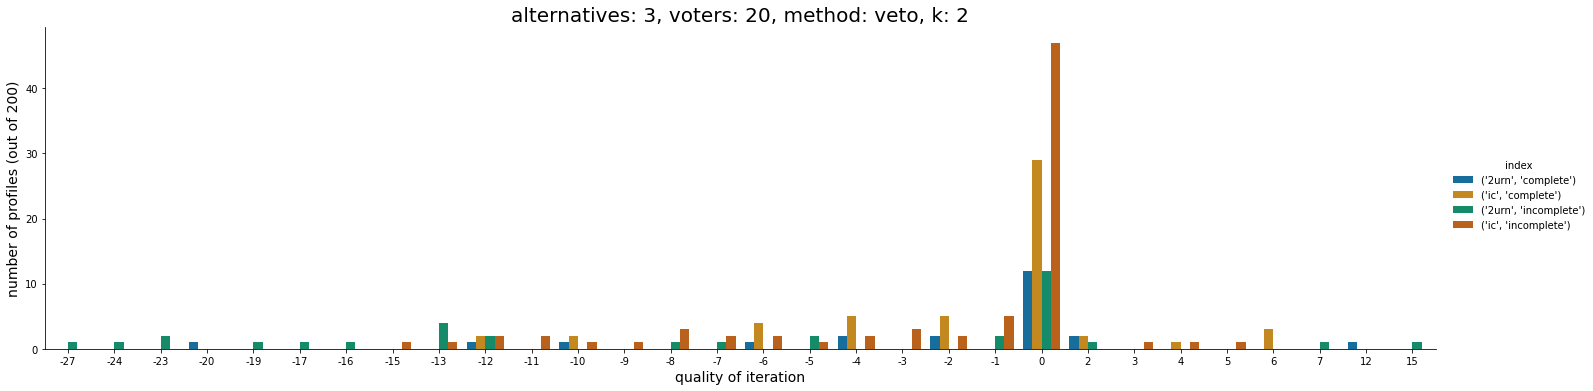

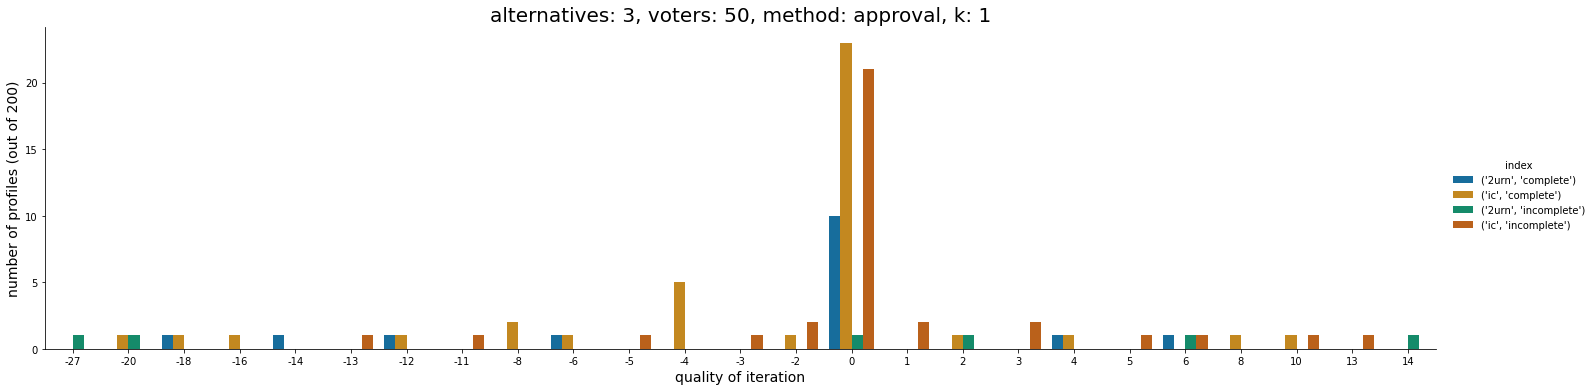

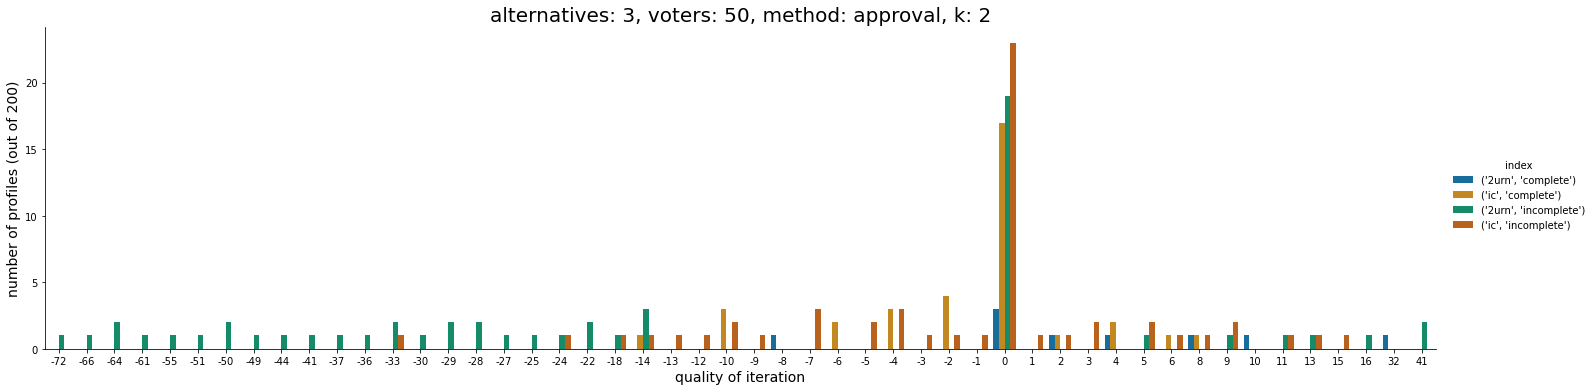

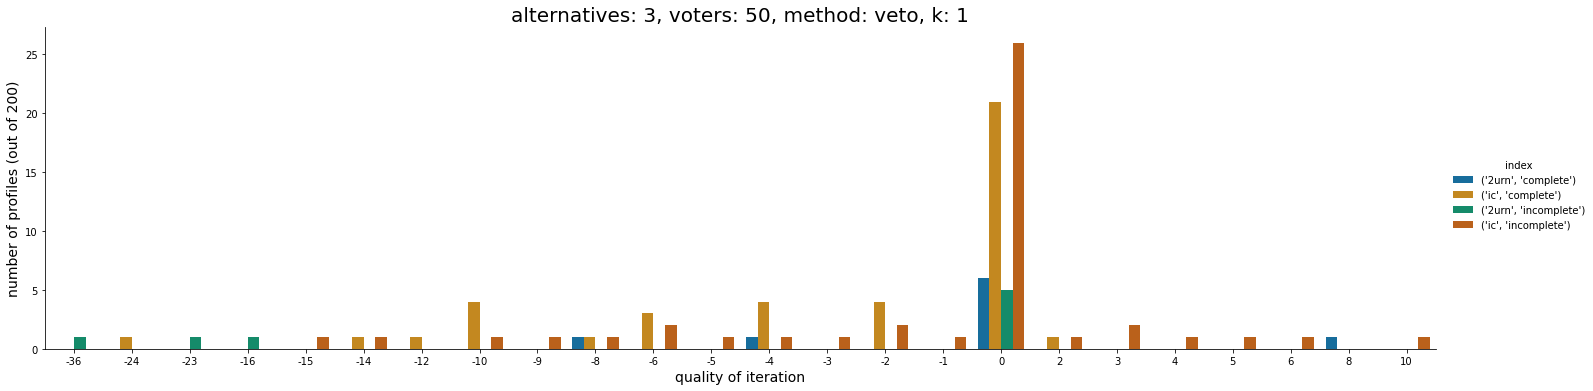

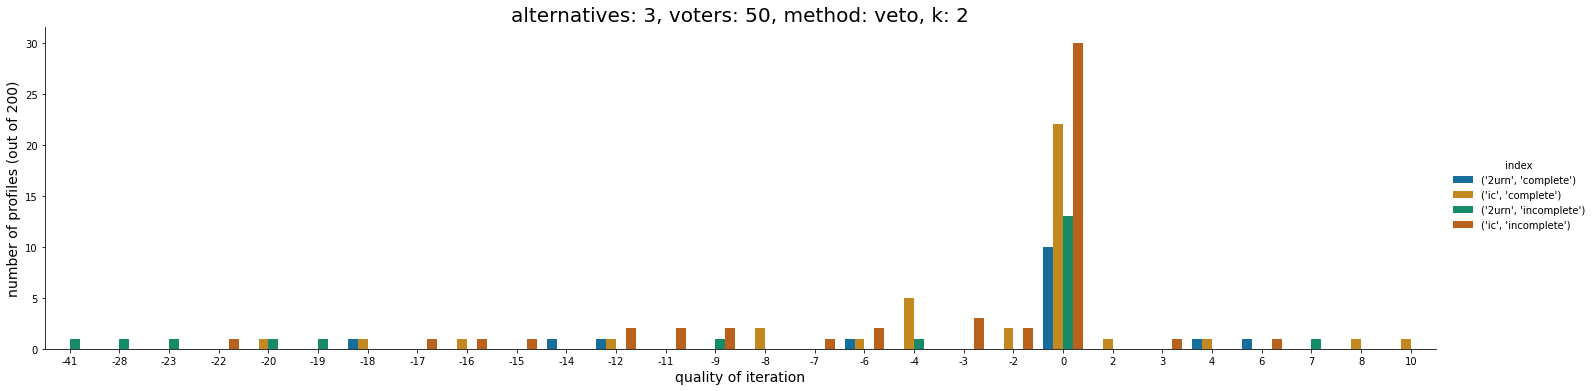

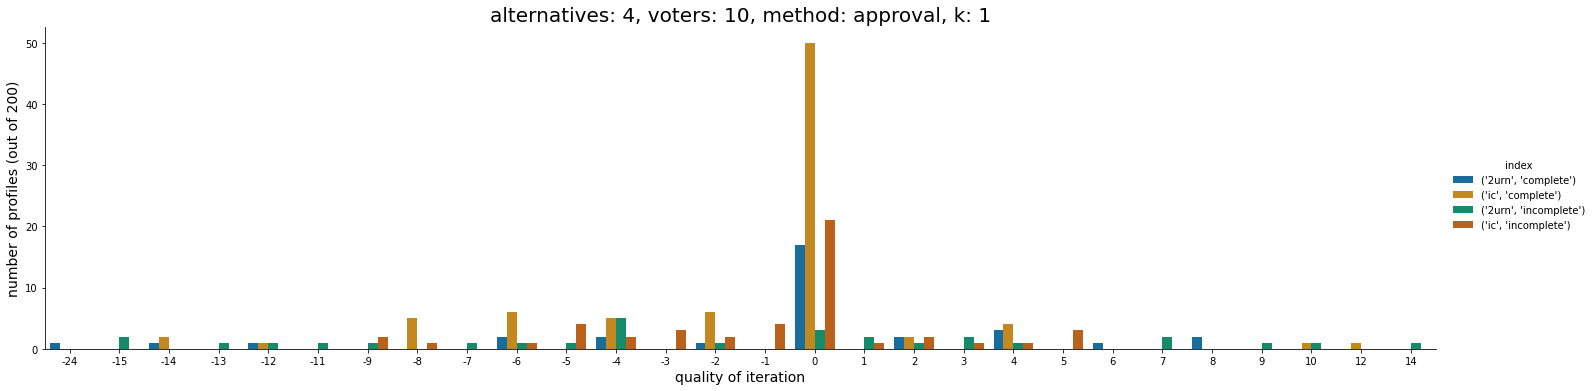

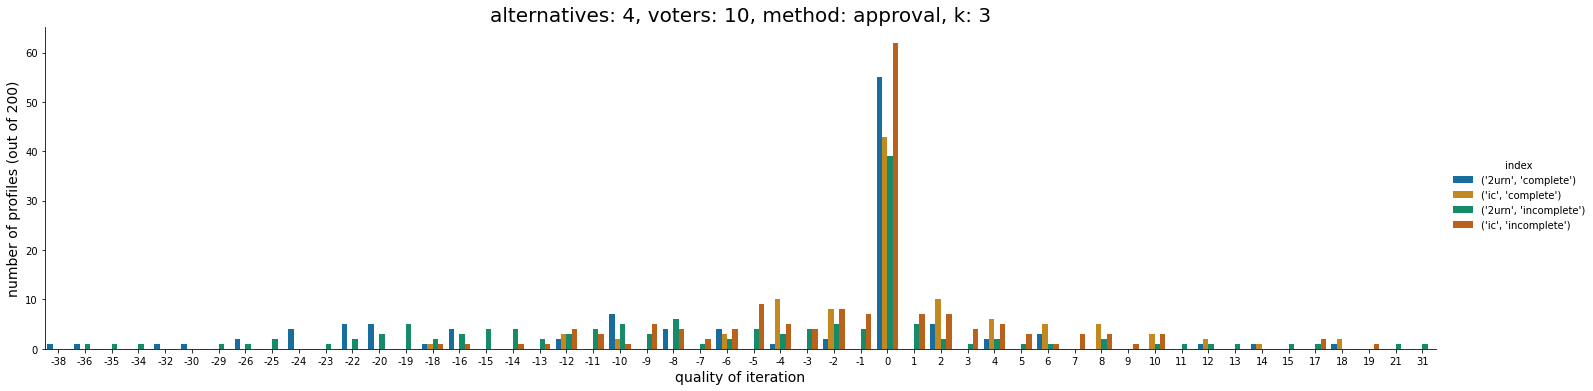

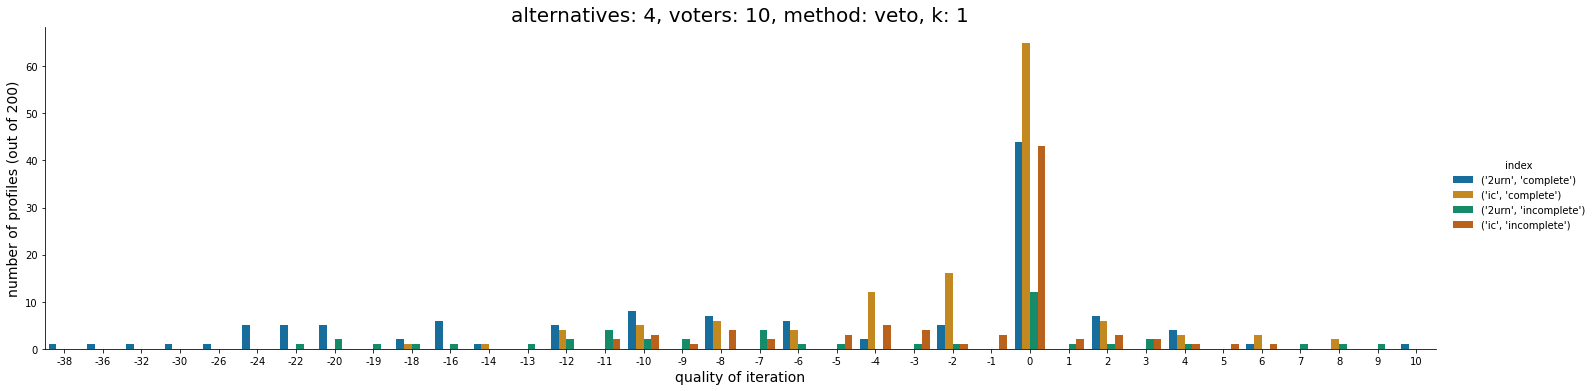

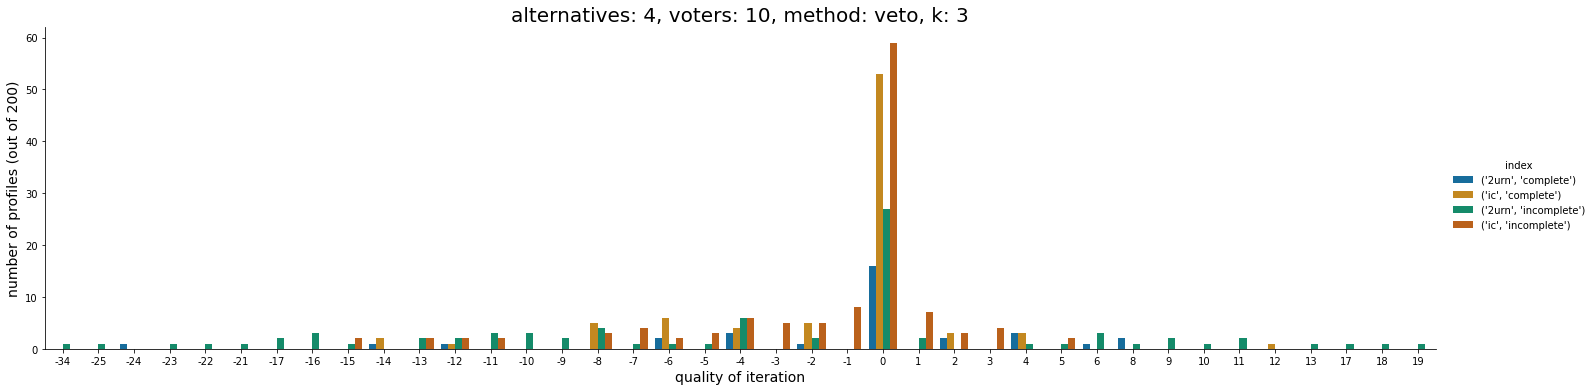

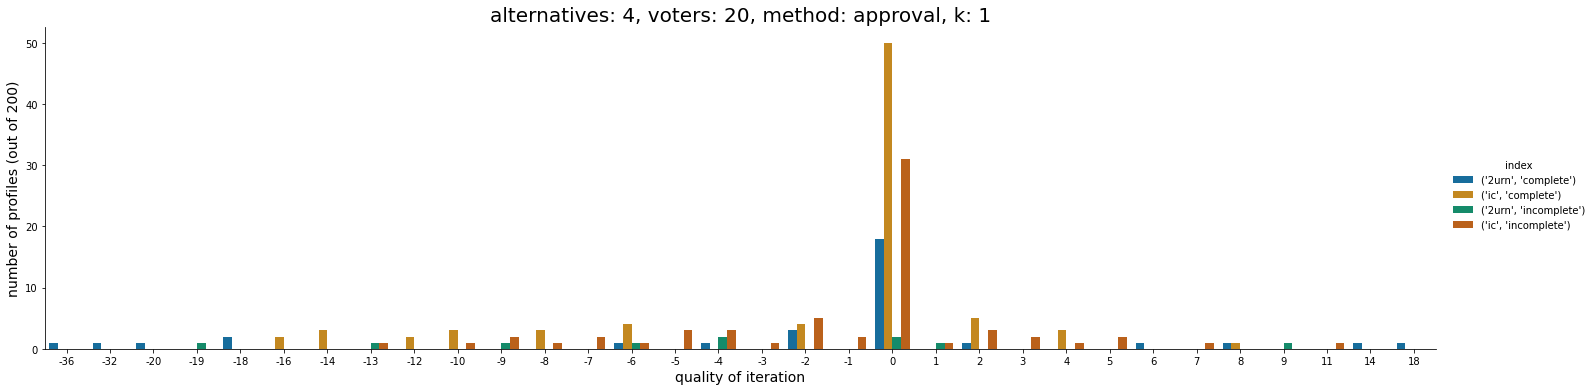

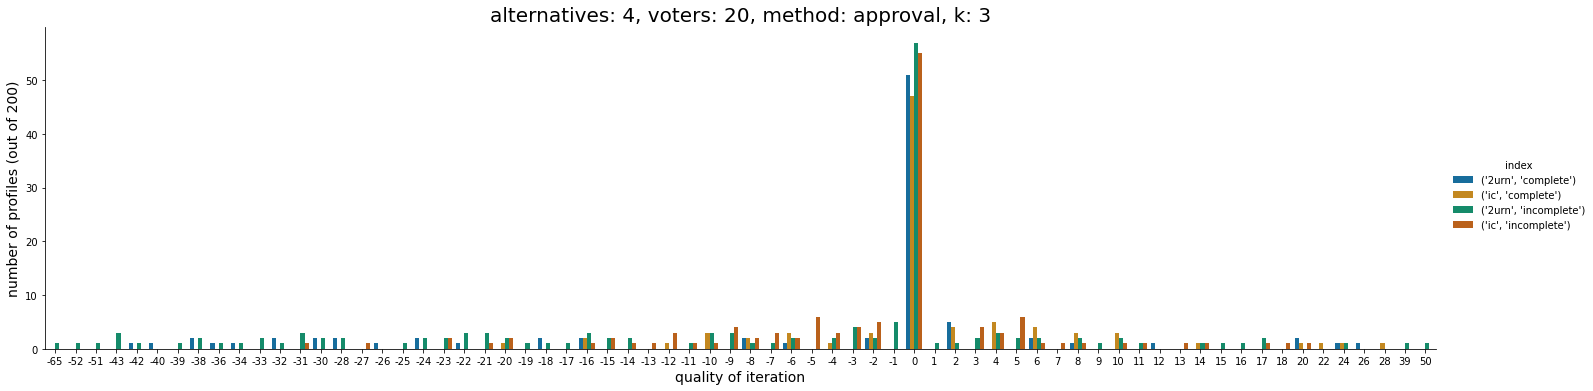

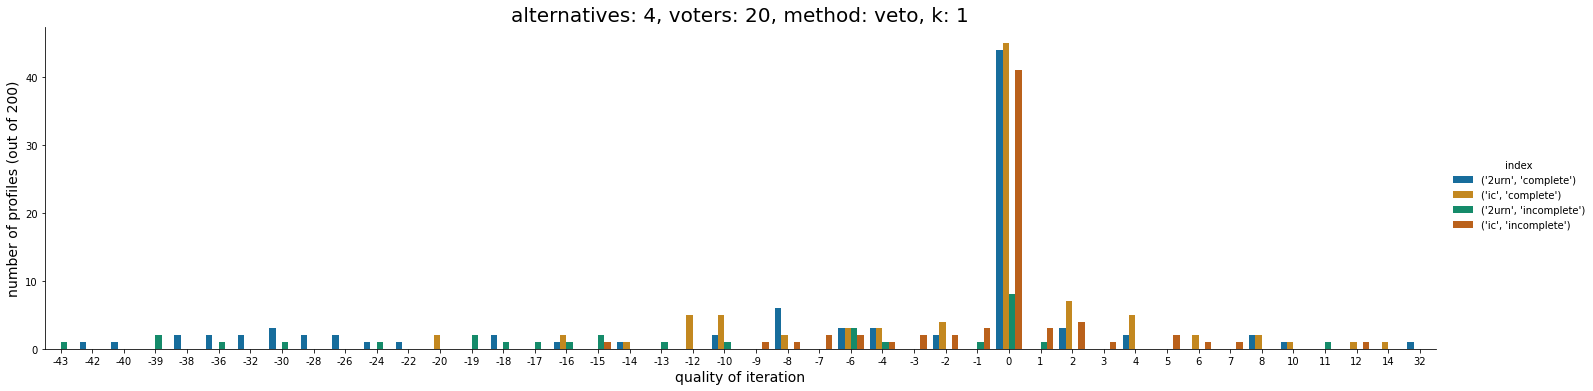

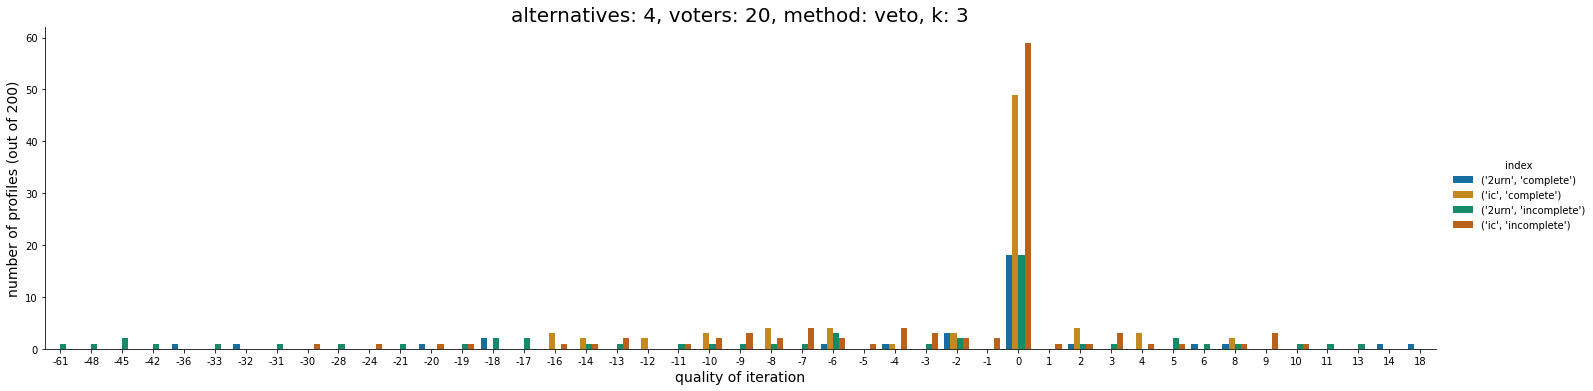

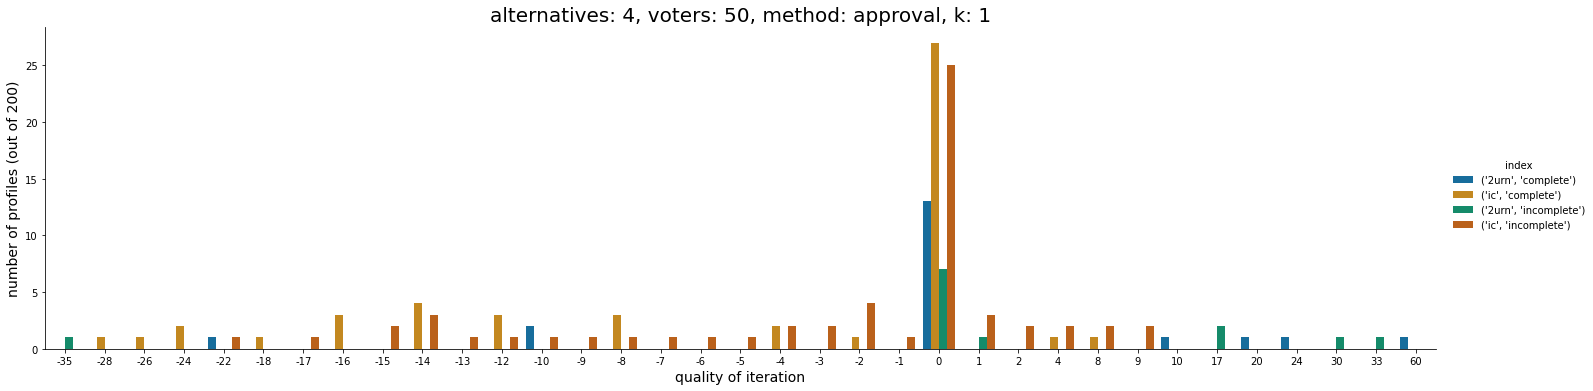

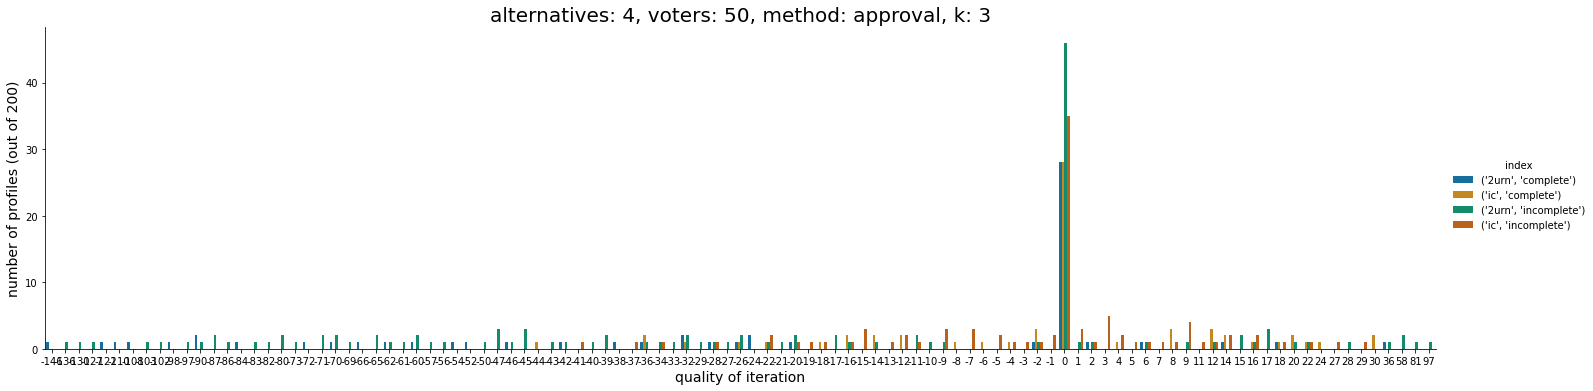

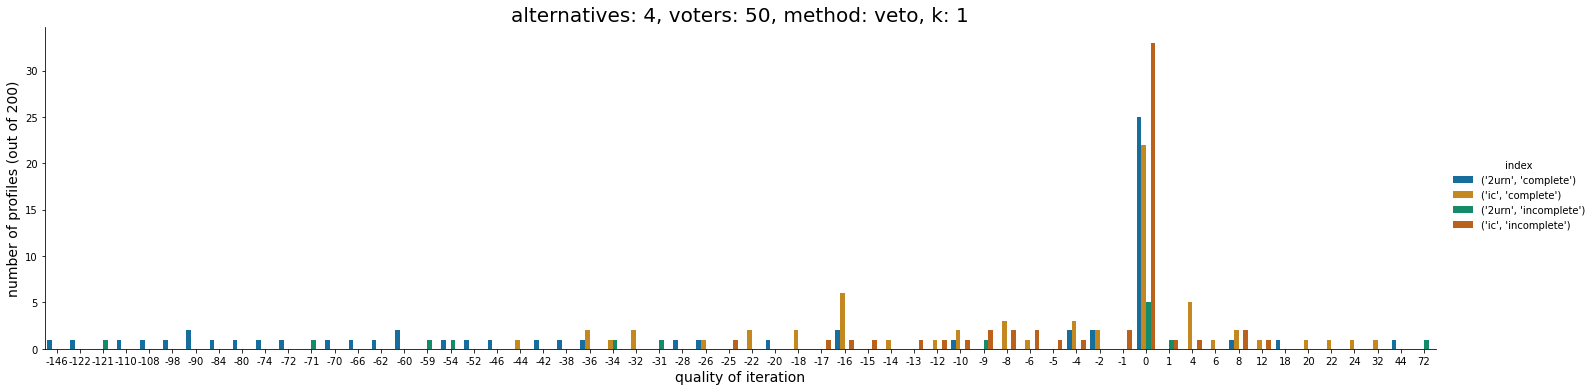

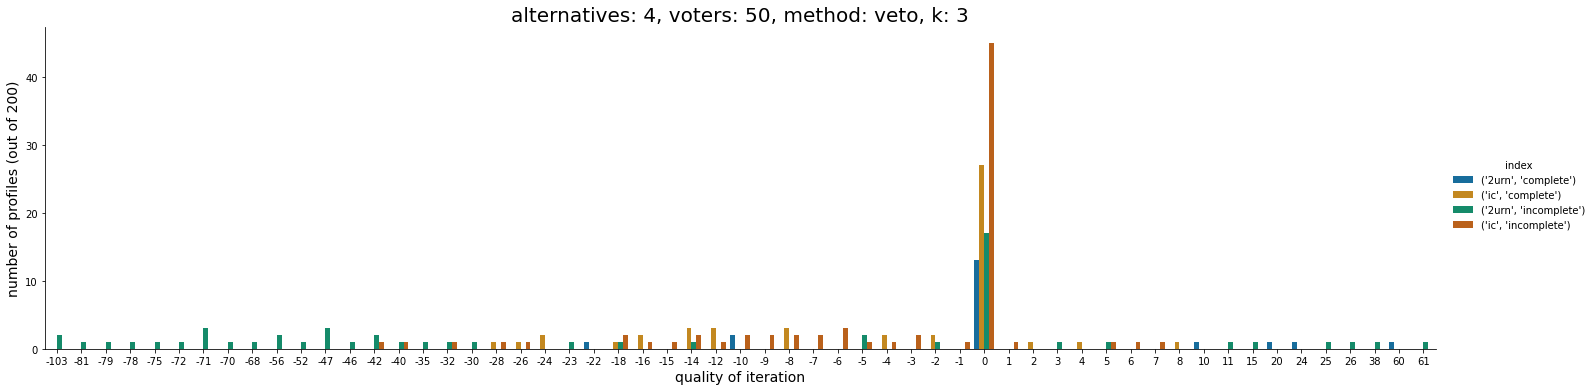

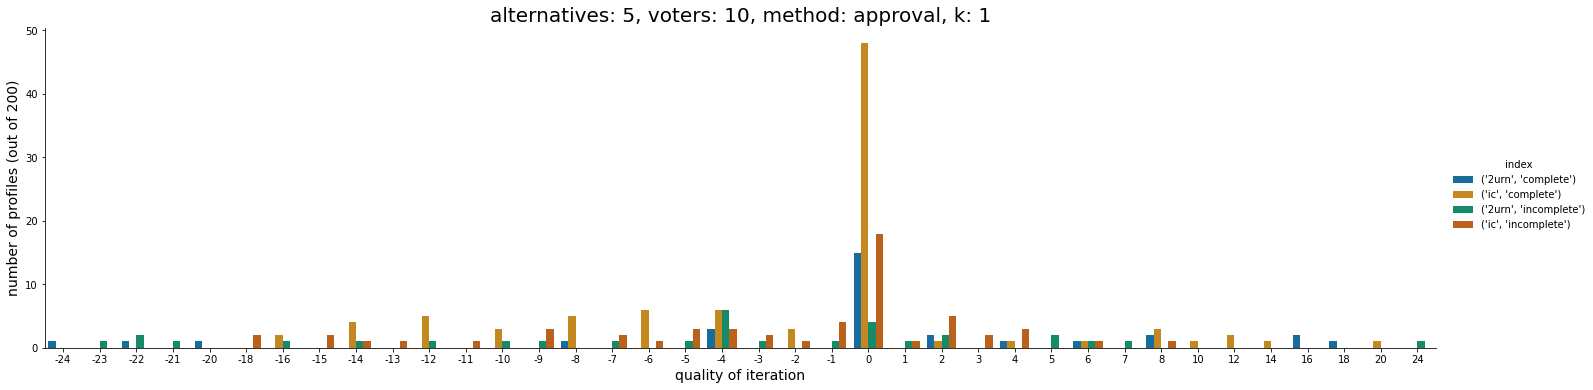

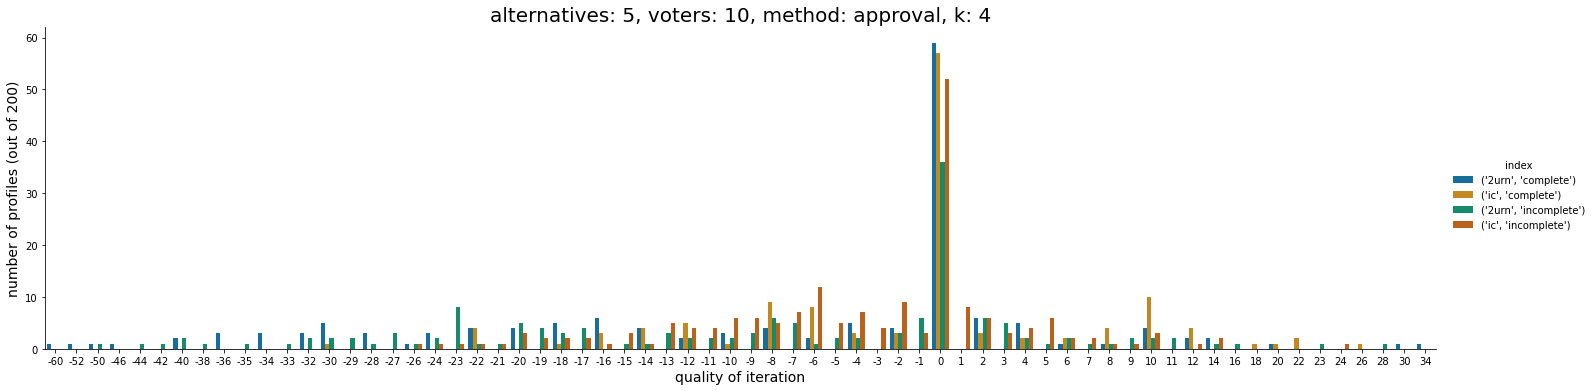

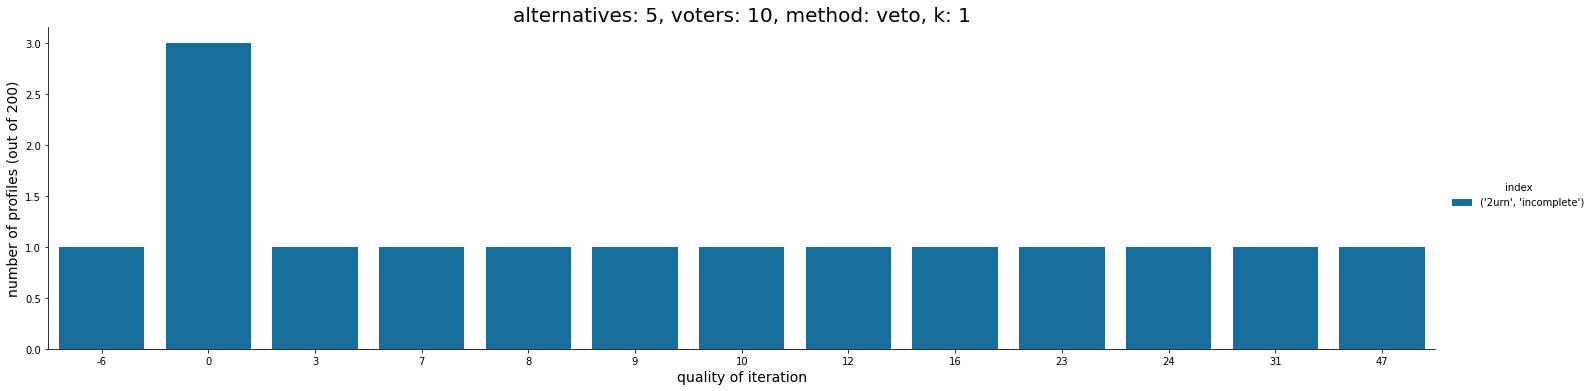

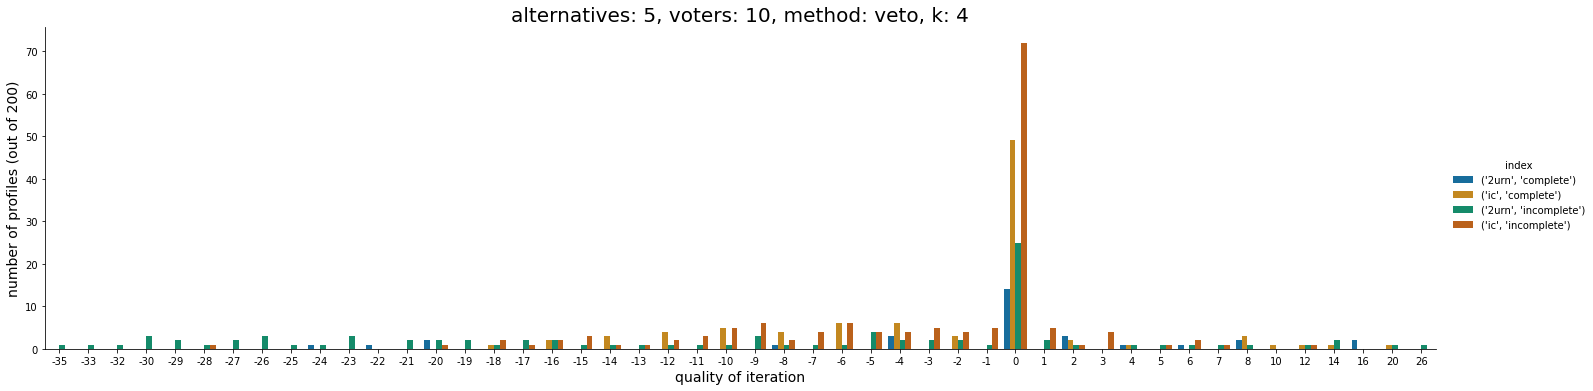

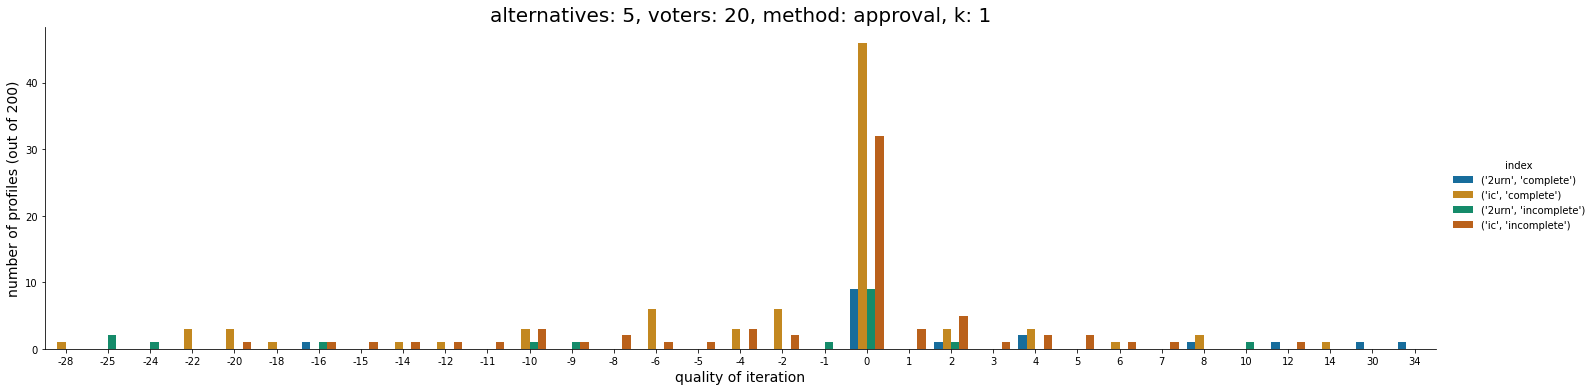

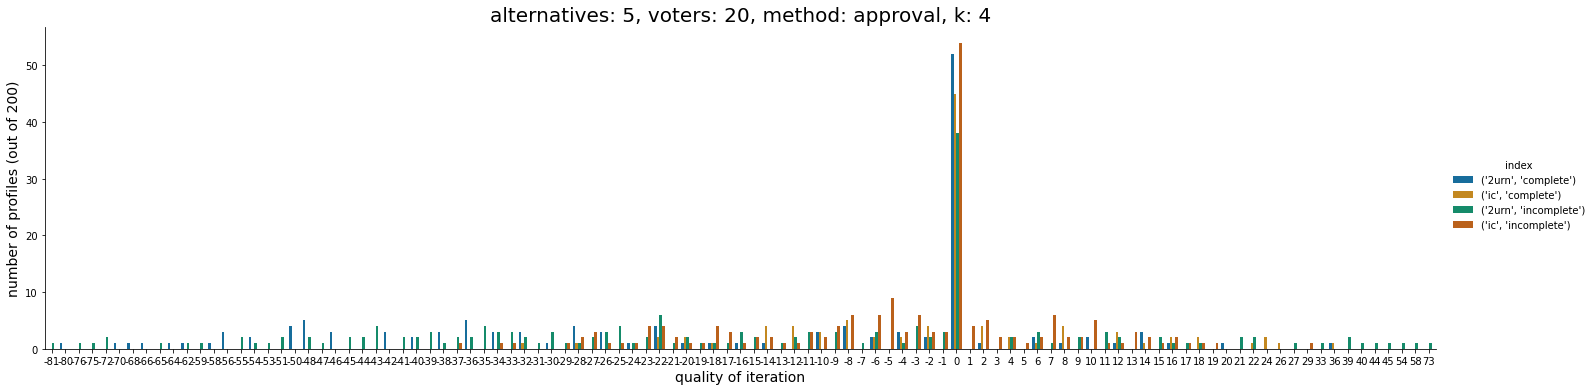

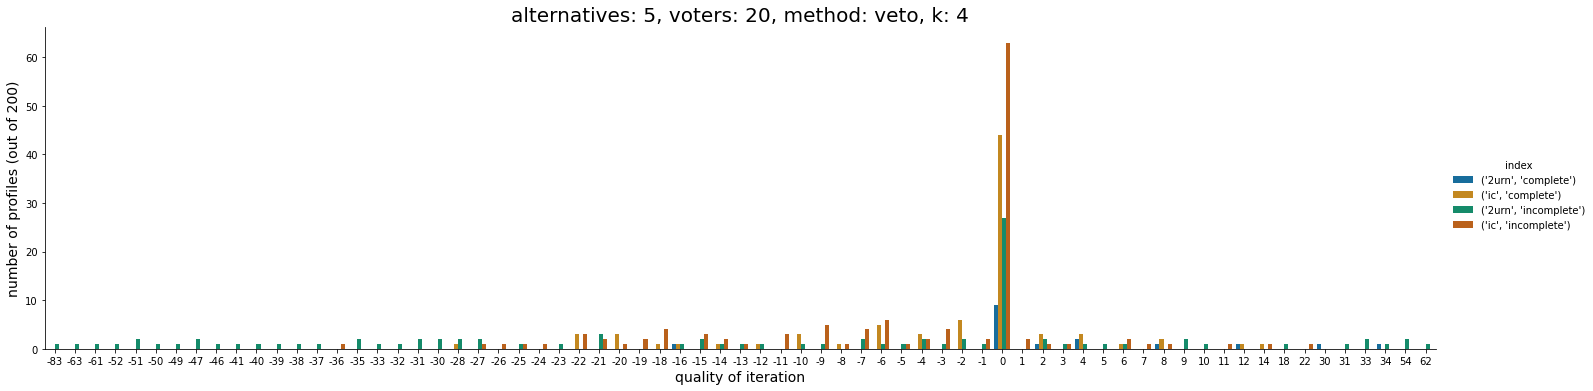

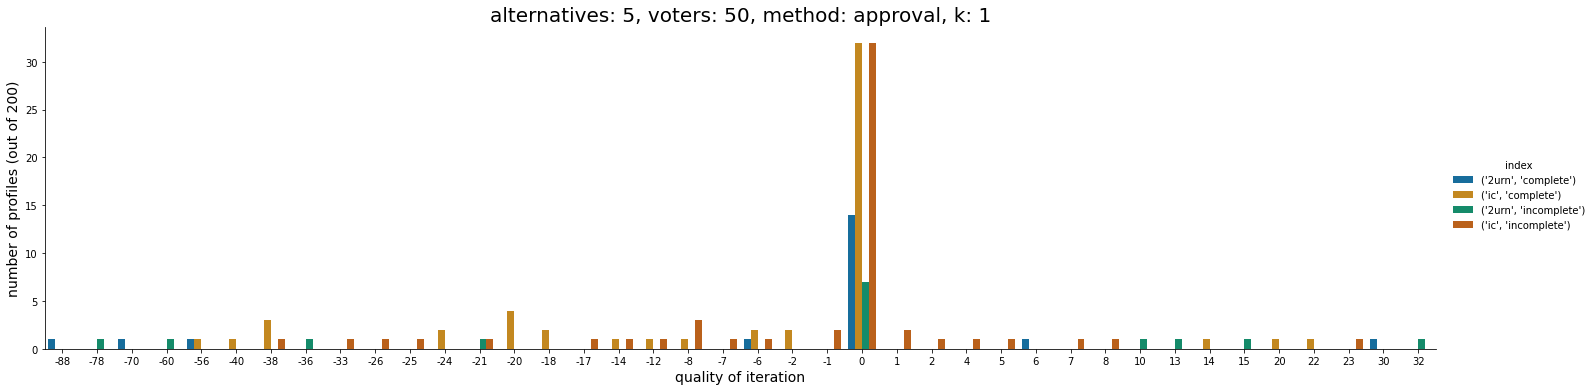

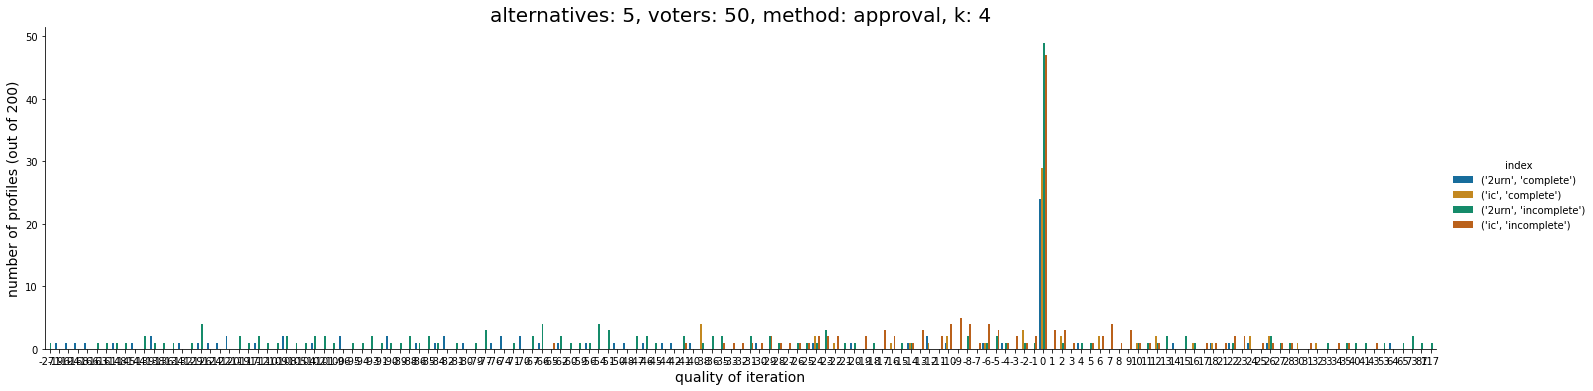

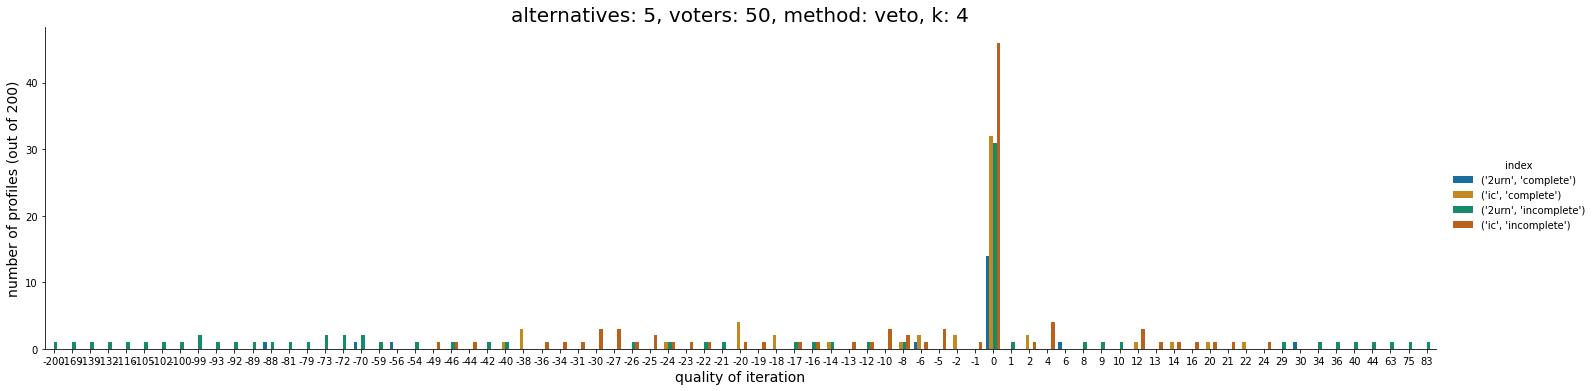

In [17]:
for num_alt in [3, 4, 5, 6]:
    for num_vot in [10, 20, 50]:
        for method in ['approval', 'veto']:
            for k in [1, num_alt-1]:
                try:
                    dft = df.loc[(num_alt, num_vot, slice(None), slice(None), method, k)]
                    dft.reset_index(inplace=True)
                    dft['index'] = dft.apply(lambda row: (row['data_type'], {True: 'complete', False: 'incomplete'}[row['completeness']]), axis=1)
                    sns.catplot(data=dft, x =0, kind='count', hue='index', height=5, aspect=4, palette="colorblind")
                    plt.title(f'alternatives: {num_alt}, voters: {num_vot}, method: {method}, k: {k}', fontsize=20)
                    plt.ylabel('number of profiles (out of 200)', fontsize=14)
                    plt.xlabel('quality of iteration', fontsize=14)
                    plt.show()
                except (KeyError, ValueError):
                    pass

# two

In [19]:
df=pd.DataFrame(pd.concat(convergence_rounds_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']
df.reset_index(inplace=True)
df['k'] = df['k'].apply(lambda x: '1' if x==1 else 'num_alt-1')

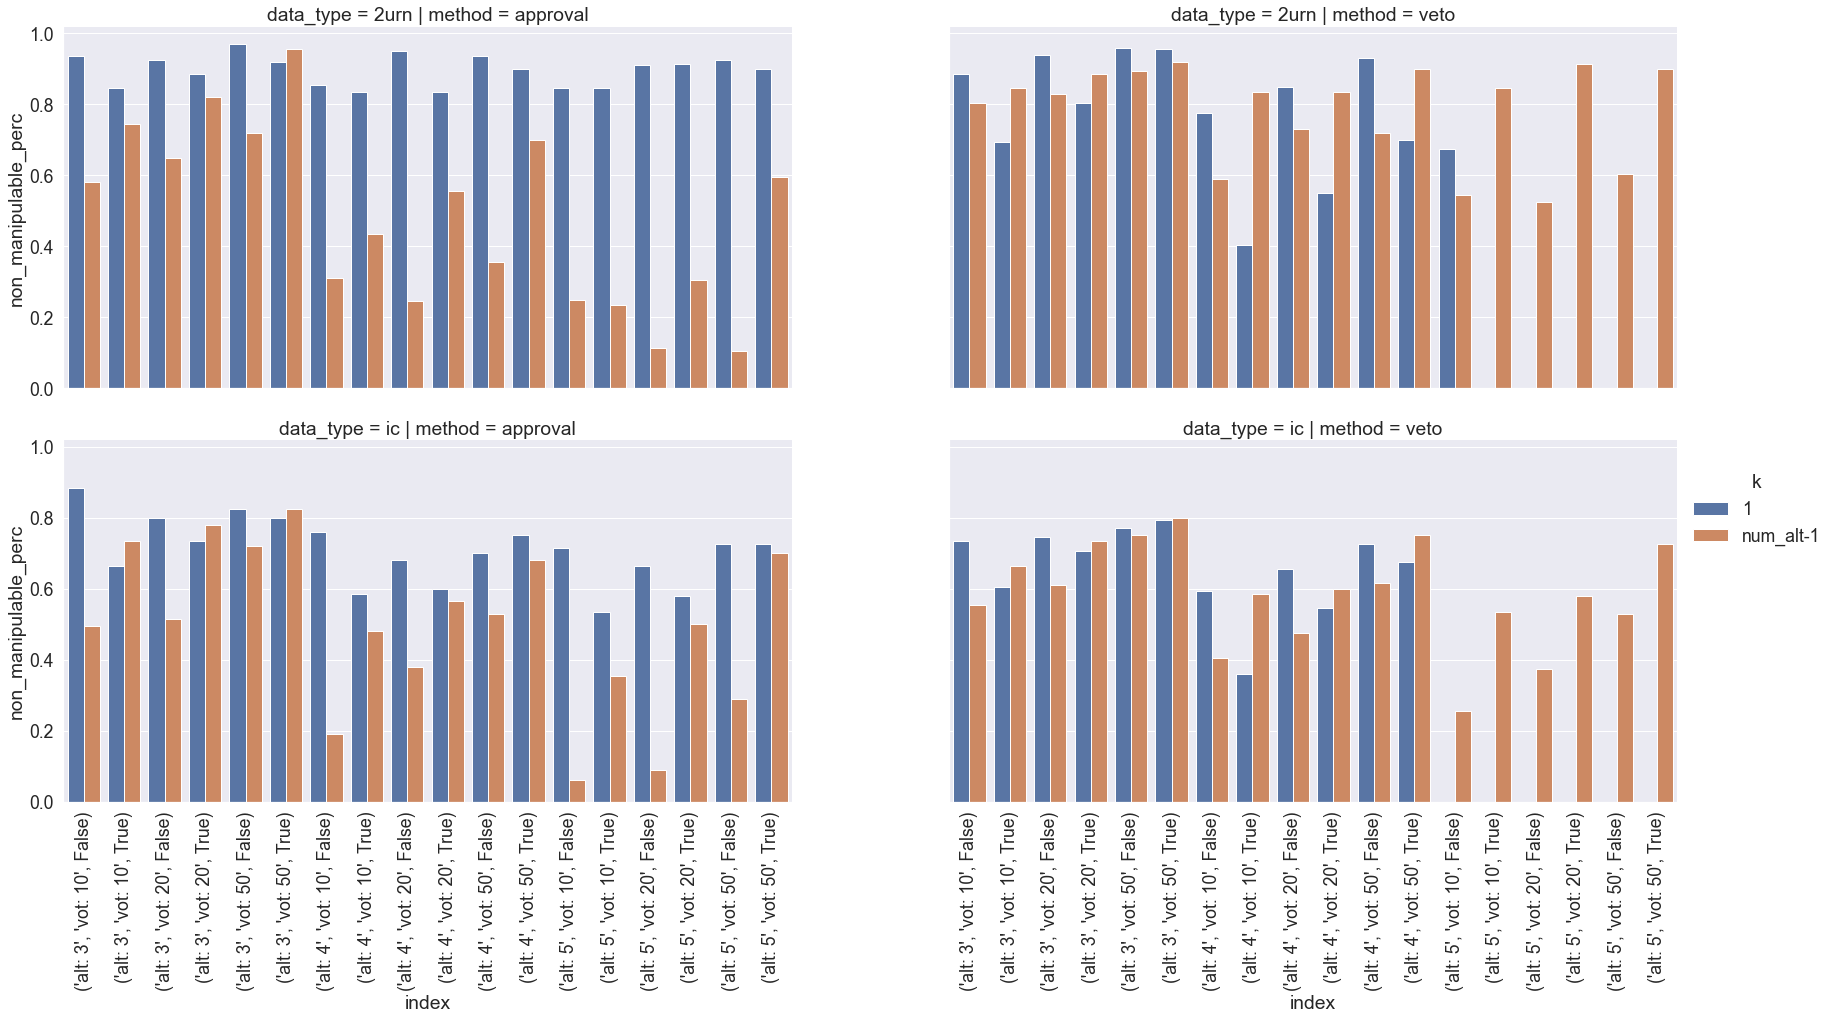

In [21]:
dft=df.groupby(['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']).apply(lambda x: (x['result']==0).sum()/len(x)).reset_index()
dft.rename(columns={0: 'non_manipulable_perc'}, inplace=True)
dft['index'] = dft.apply(lambda row: (f'alt: {row["num_alt"]}', f'vot: {row["num_vot"]}', row["completeness"]), axis=1)
sns.set(font_scale=1.6)
g=sns.catplot(x="index",
            y='non_manipulable_perc',
            hue="k",
            col='method',
            row='data_type',
            data=dft,
            kind="bar",
            height=6, aspect=2)
g.set_xticklabels(rotation=90)

# four

In [43]:
df=pd.DataFrame(pd.concat(convergence_rounds_all)).reset_index(level=6, drop=True)
df.index.names = ['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']
df.reset_index(inplace=True)
df.drop(columns=['result'], inplace=True)

df['same_winner_times'] = df.apply(lambda row: qualities_of_winners[(row['completeness'], row['data_type'], row['num_vot'], row['num_alt'], row['method'], row['k'])][1], axis=1)
df['k'] = df['k'].apply(lambda x: '1' if x==1 else 'num_alt-1')

In [44]:
df

,num_alt,num_vot,data_type,completeness,method,k,same_winner_times
0,3,10,2urn,True,approval,1,8
1,3,10,2urn,True,approval,1,8
2,3,10,2urn,True,approval,1,8
3,3,10,2urn,True,approval,1,8
4,3,10,2urn,True,approval,1,8
...,...,...,...,...,...,...,...
26441,5,50,ic,False,veto,num_alt-1,46
26442,5,50,ic,False,veto,num_alt-1,46
26443,5,50,ic,False,veto,num_alt-1,46
26444,5,50,ic,False,veto,num_alt-1,46


In [46]:
dft

,num_alt,num_vot,data_type,completeness,method,k,0,index
0,3,10,2urn,False,approval,1,0.010,"(alt: 3, vot: 10, False)"
1,3,10,2urn,False,approval,num_alt-1,0.135,"(alt: 3, vot: 10, False)"
2,3,10,2urn,False,veto,1,0.050,"(alt: 3, vot: 10, False)"
3,3,10,2urn,False,veto,num_alt-1,0.045,"(alt: 3, vot: 10, False)"
4,3,10,2urn,True,approval,1,0.040,"(alt: 3, vot: 10, True)"
...,...,...,...,...,...,...,...,...
128,5,50,ic,False,approval,num_alt-1,0.230,"(alt: 5, vot: 50, False)"
129,5,50,ic,False,veto,num_alt-1,0.230,"(alt: 5, vot: 50, False)"
130,5,50,ic,True,approval,1,0.150,"(alt: 5, vot: 50, True)"
131,5,50,ic,True,approval,num_alt-1,0.135,"(alt: 5, vot: 50, True)"


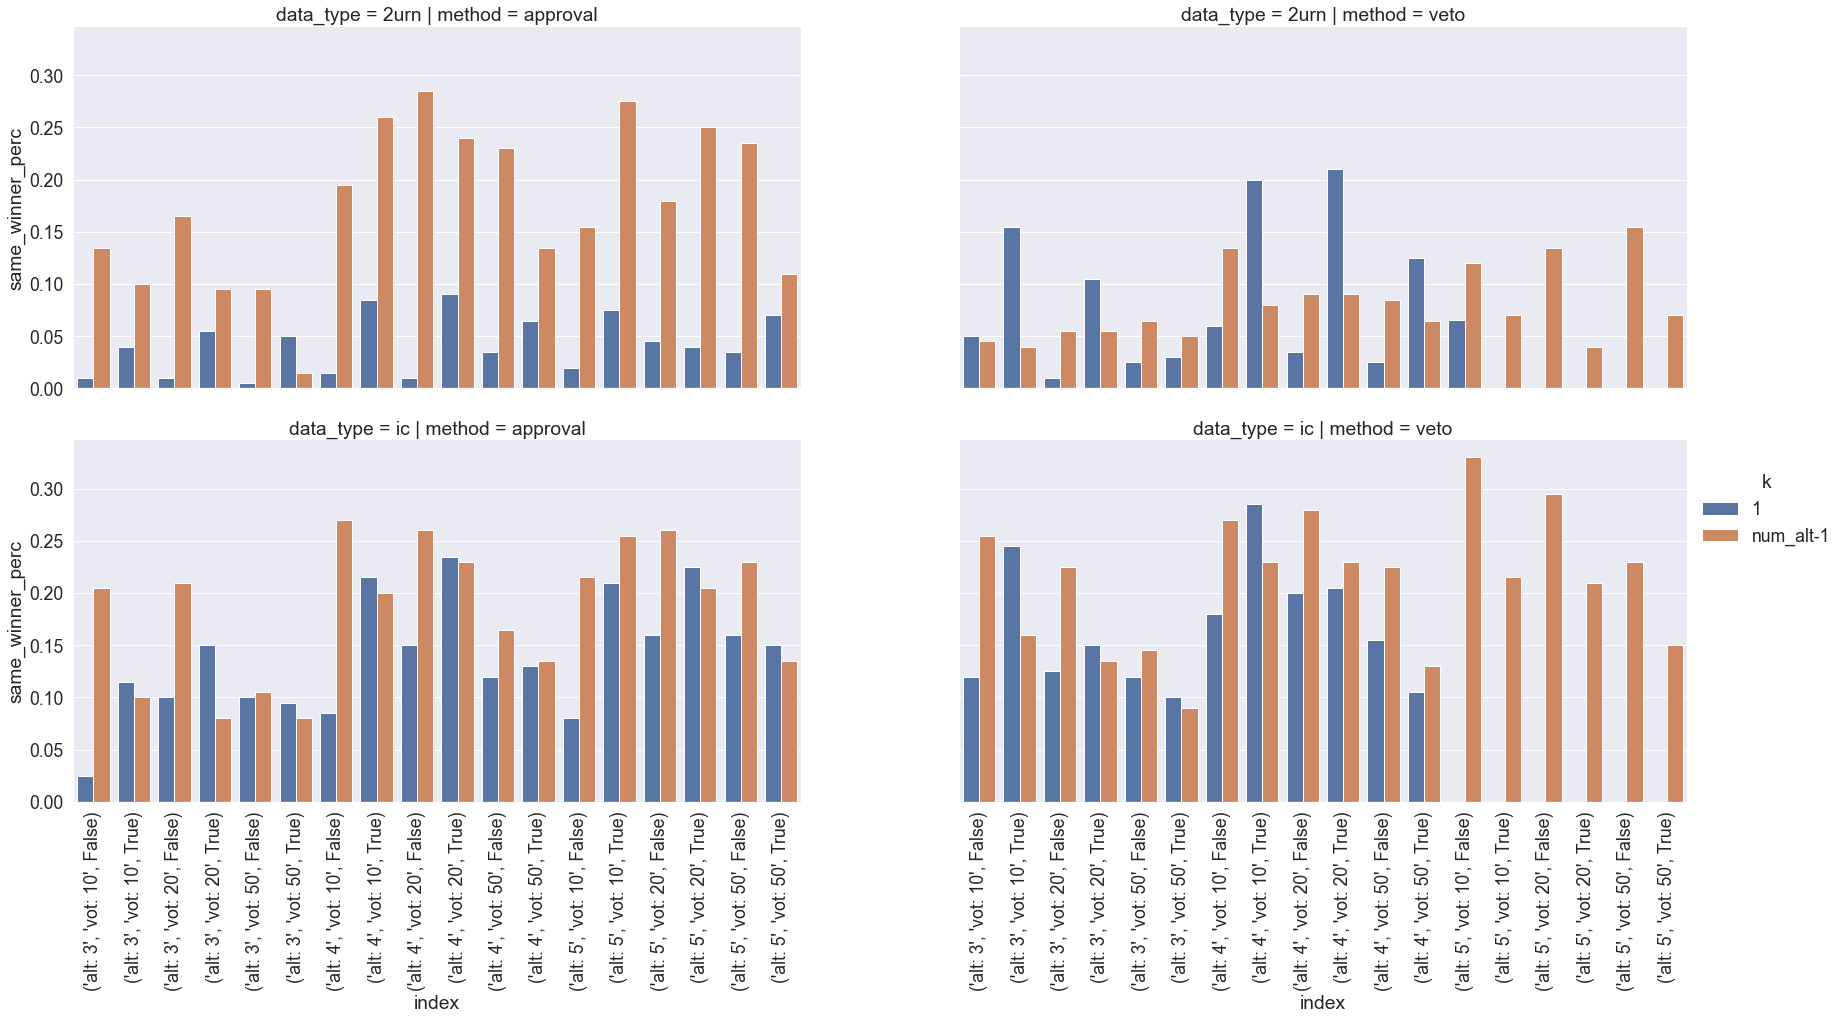

In [47]:
dft=df.groupby(['num_alt', 'num_vot', 'data_type', 'completeness', 'method', 'k']).apply(lambda x: (x['same_winner_times'].mean())/len(x)).reset_index()
dft.rename(columns={0: 'same_winner_perc'}, inplace=True)
dft['index'] = dft.apply(lambda row: (f'alt: {row["num_alt"]}', f'vot: {row["num_vot"]}', row["completeness"]), axis=1)
sns.set(font_scale=1.6)
g=sns.catplot(x="index",
            y='same_winner_perc',
            hue="k",
            col='method',
            row='data_type',
            data=dft,
            kind="bar",
            height=6, aspect=2)
g.set_xticklabels(rotation=90)